# Run Ref_30min_ext

In [1]:
# Env: sc2_v0
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import calendar
import os

In [2]:
site = 'ojp'
site_longname = 'BERMS Old Jack Pine, Saskatchewan, Canada'
y_start = 1997
y_end = 2010

labels = ['Ref', 'Ref_30min_ext']

root_path = '/home/lalandmi/eccc/classic-develop/outputFiles/SnowMIP/'+site+'/'
paths = [root_path+'run_'+label for label in labels]

# ds_yr_list = [xr.open_mfdataset(path+'/*_annually.nc').squeeze().load() for path in paths]
# ds_mo_list = [xr.open_mfdataset(path+'/*_monthly.nc').squeeze().load() for path in paths]
ds_d_list = [xr.open_mfdataset(path+'/*_daily.nc').squeeze().load() for path in paths]
# ds_hh_list = [xr.open_mfdataset(path+'/*_halfhourly.nc').squeeze().load() for path in paths]

In [3]:
path = "/home/lalandmi/eccc/classic-develop/inputFiles/SnowMIP/"+site
rsfile = xr.open_dataset(path+'/rsfile_spinup-final_'+labels[0]+'.nc')

In [4]:
def assign_center_depth(ds, rsfile):
    layer_c = []
    for i in range(len(rsfile.DELZ)):
        if i == 0:
            layer_c.append(rsfile.DELZ.cumsum().values[i]/2)
        else:
            layer_c.append(rsfile.DELZ.cumsum().values[i-1] + rsfile.DELZ.values[i]/2)
    with xr.set_options(keep_attrs=True):
        ds = ds.assign_coords(layer=ds.layer*0+layer_c)
    return ds

In [5]:
for i in range(len(labels)):
    # ds_yr_list[i] = assign_center_depth(ds_yr_list[i], rsfile)
    # ds_mo_list[i] = assign_center_depth(ds_mo_list[i], rsfile)
    ds_d_list[i] = assign_center_depth(ds_d_list[i], rsfile)
    # ds_hh_list[i] = assign_center_depth(ds_hh_list[i], rsfile)

In [6]:
# Paul's SnowMIP data

path_paul = '/home/lalandmi/Dropbox/data/SnowMIP/Paul/CLASS_Results'
label_paul = "SnowMIP"

df_paul = pd.read_csv(path_paul+'/CLASS_sv_REF_'+site+'_'+str(y_start)+'_'+str(y_end)+'.txt', delim_whitespace=True)
df_paul.index = pd.to_datetime(df_paul[['year', 'month', 'day', 'hour']]).values
df_paul= df_paul.drop(columns=['year', 'month', 'day', 'hour'])
df_paul.albsn = df_paul.albsn.replace({0 : np.nan})
df_paul.albs = df_paul.albs.replace({0 : np.nan})
df_paul.tsn = df_paul.tsn.replace({-999 : np.nan})
df_paul.tsns = df_paul.tsns.replace({-999 : np.nan})
ds_paul_h = df_paul.to_xarray()
ds_paul_h = ds_paul_h.rename({'index': 'time'})
ds_paul_h.load()

ds_paul_d = ds_paul_h.resample(time='D').mean().load()
ds_paul_d = ds_paul_d.assign_coords(layer=[0.05 , 0.225, 2.225]) # center of Paul's soil layers (DELZ = [0.1, 0.25, 3.75])

In [7]:
# Combine the soil temperature in one variable
ds_paul_d = ds_paul_d.assign(
    tsl=(('layer', 'time'), [
        list(ds_paul_d['tsl:1'].values),
        list(ds_paul_d['tsl:2'].values),
        list(ds_paul_d['tsl:3'].values),
    ])
)

Text(0.5, 0.98, 'BERMS Old Jack Pine, Saskatchewan, Canada')

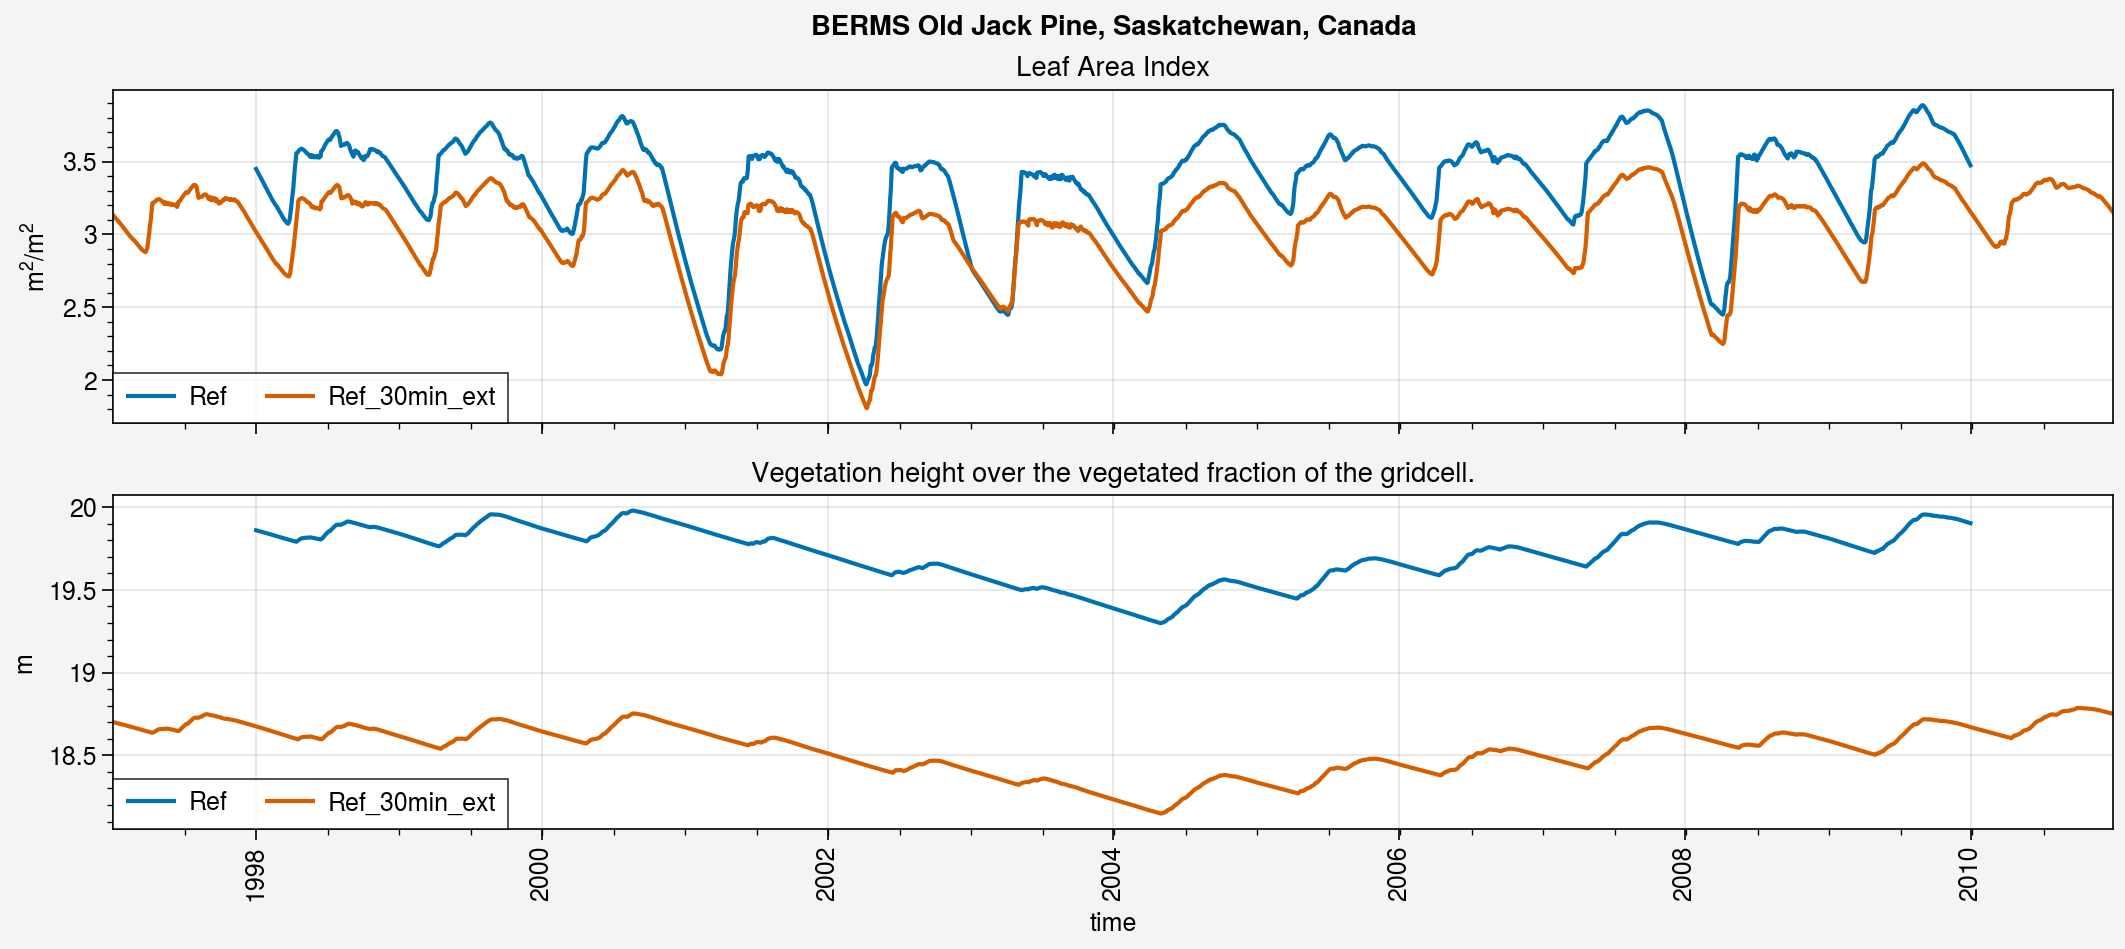

In [8]:
fig, axs = pplt.subplots(ncols=1, nrows=2, refaspect=6, refwidth=10, sharey=0)

for ds_d, label in zip(ds_d_list, labels):
    axs[0].plot(ds_d.lai, label=label)
    axs[1].plot(ds_d.vegHeight, label=label)

axs[0].format(ylabel=ds_d_list[0].lai.units, title=ds_d_list[0].lai.long_name)
axs[1].format(ylabel=ds_d_list[0].vegHeight.units, title=ds_d_list[0].vegHeight.long_name)

for ax in axs:
    ax.legend()

fig.suptitle(site_longname)

Text(0.5, 0.98, 'BERMS Old Jack Pine, Saskatchewan, Canada (1997-2010)')

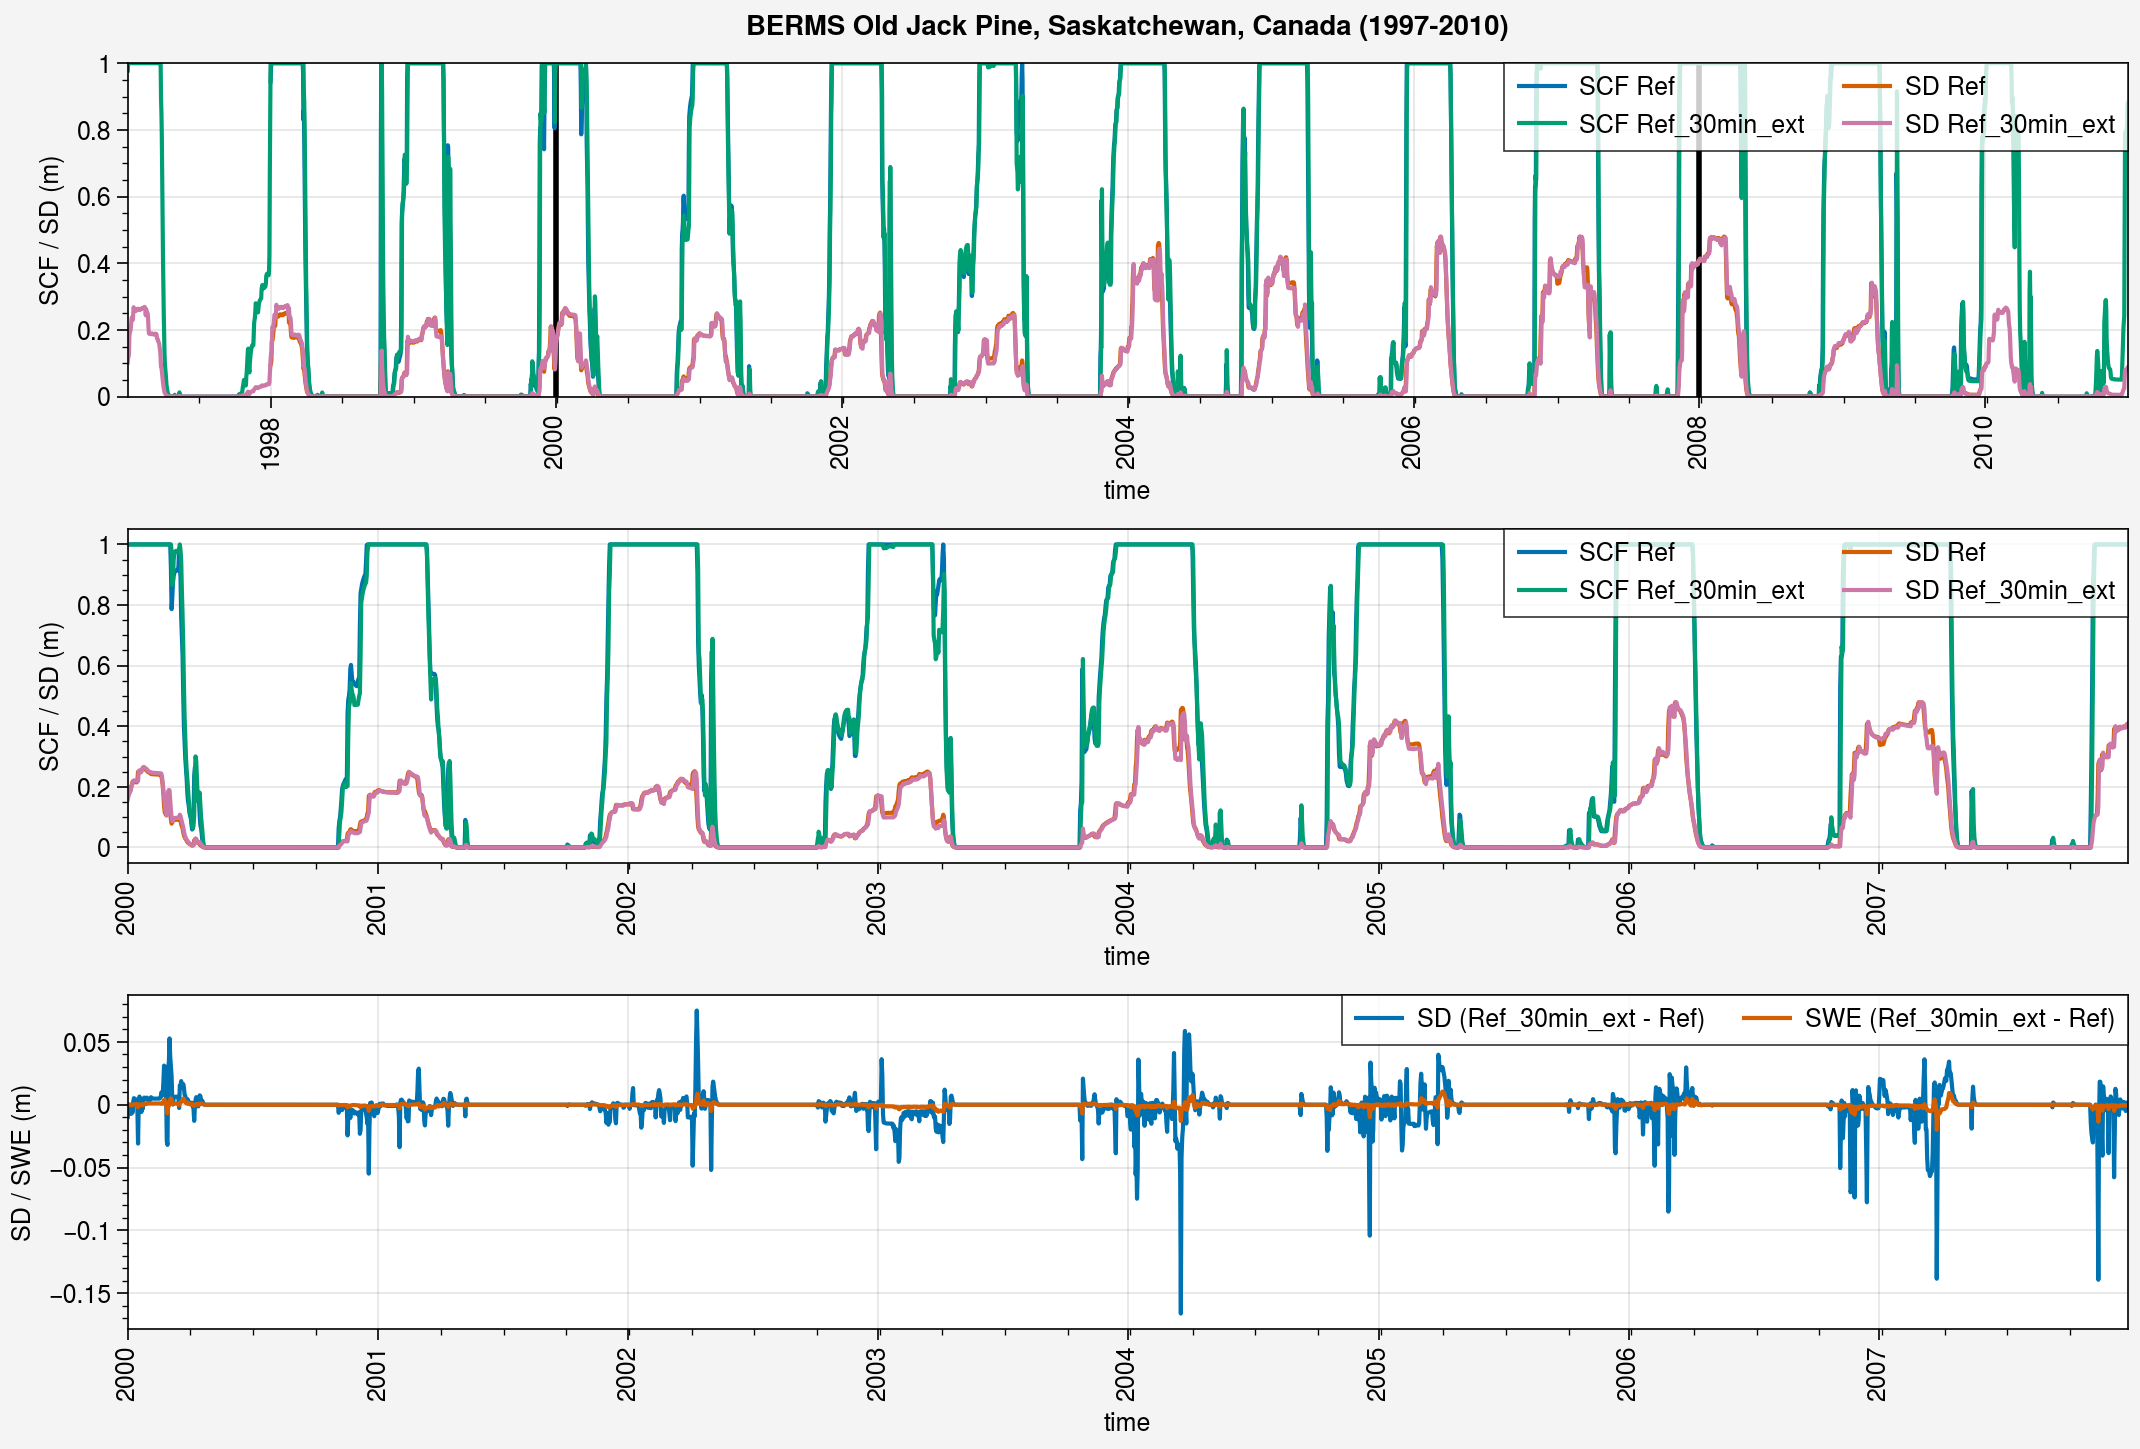

In [9]:
if len(labels) > 1:
    nrows = 3
else: 
    nrows = 2
    
fig, axs = pplt.subplots(ncols=1, nrows=nrows, refaspect=6, refwidth=10, share=0)

##################
### All period ###
##################
start = str(y_start)
end = str(y_end)

for ds_d, label in zip(ds_d_list, labels):
    axs[0].plot(ds_d.snc.sel(time=slice(start,end)), label='SCF '+label)
    axs[0].plot(ds_d.snd.sel(time=slice(start,end)), label='SD '+label)

axs[0].legend(ncols=2, loc='ur')
axs[0].format(
    ylabel='SCF / SD (m)'
)


############
### Zoom ###
############
start = str(y_start+3)
end = str(y_end-3)

for ds_d, label in zip(ds_d_list, labels):
    axs[1].plot(ds_d.snc.sel(time=slice(start,end)), label='SCF '+label)
    axs[1].plot(ds_d.snd.sel(time=slice(start,end)), label='SD '+label)

axs[0].vlines(ds_d_list[0].sel(time=slice(start,end)).time[0], ds_d_list[0].snc.min(), ds_d_list[0].snc.max(), color='k', lw=2)
axs[0].vlines(ds_d_list[0].sel(time=slice(start,end)).time[-1], ds_d_list[0].snc.min(), ds_d_list[0].snc.max(), color='k', lw=2)

axs[1].legend(ncols=2, loc='ur')
axs[1].format(
    ylabel='SCF / SD (m)'
)

if nrows == 3:
    #####################
    ### SWE / SD diff ###
    #####################
    axs[2].plot((ds_d_list[1]-ds_d_list[0]).snd.sel(time=slice(start,end)), label='SD ('+labels[1]+' - '+labels[0]+')')
    axs[2].plot(((ds_d_list[1]-ds_d_list[0]).snw*1e-3).sel(time=slice(start,end)), label='SWE ('+labels[1]+' - '+labels[0]+')')
    
    axs[2].legend(ncols=2)
    axs[2].format(
        ylabel='SD / SWE (m)'
    )

fig.suptitle(site_longname+' ('+str(y_start)+'-'+str(y_end)+')')


## Compare with obs

In [10]:
path_menard2019 = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all'

ds_h_eval_menard2019 = xr.open_dataset(path_menard2019+'/obs_insitu_'+site+'_'+str(y_start)+'_'+str(y_end)+'.nc').load()
ds_d_eval_menard2019 = ds_h_eval_menard2019.resample(time='D').mean().load()
ds_h_eval_menard2019

<xarray.Dataset> Size: 6MB
Dimensions:       (time: 113952, sdepth: 4)
Coordinates:
  * time          (time) datetime64[ns] 912kB 1997-10-01T01:00:00 ... 2010-10-01
  * sdepth        (sdepth) float32 16B 0.1 0.2 0.5 1.0
Data variables:
    albs          (time) float32 456kB nan nan nan nan nan ... nan nan nan nan
    rlus          (time) float32 456kB 356.0 354.7 355.5 ... 336.9 332.3 327.4
    snd_can_auto  (time) float32 456kB nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    snd_gap_auto  (time) float32 456kB 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    snd_man       (time) float32 456kB nan nan nan nan nan ... nan nan nan nan
    snw_man       (time) float32 456kB nan nan nan nan nan ... nan nan nan nan
    ts            (time) float32 456kB nan nan nan nan nan ... nan nan nan nan
    tsl           (time, sdepth) float32 2MB 13.2 13.78 9.182 ... 8.87 8.792

In [11]:
tot_year = y_end - y_start + 1
gap = 4
years = pplt.arange(y_start, y_end)
years

array([1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010])

### SD

In [12]:
ds_d_eval_menard2019

<xarray.Dataset> Size: 247kB
Dimensions:       (sdepth: 4, time: 4749)
Coordinates:
  * sdepth        (sdepth) float32 16B 0.1 0.2 0.5 1.0
  * time          (time) datetime64[ns] 38kB 1997-10-01 ... 2010-10-01
Data variables:
    albs          (time) float32 19kB 0.1143 0.1105 0.116 ... 0.1055 0.09739 nan
    rlus          (time) float32 19kB 369.8 378.0 361.2 ... 375.7 356.3 327.4
    snd_can_auto  (time) float32 19kB nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    snd_gap_auto  (time) float32 19kB 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    snd_man       (time) float32 19kB nan nan nan nan nan ... nan nan nan nan
    snw_man       (time) float32 19kB nan nan nan nan nan ... nan nan nan nan
    ts            (time) float32 19kB nan nan nan nan nan ... nan nan nan nan
    tsl           (time, sdepth) float32 76kB 13.49 13.84 9.108 ... 8.87 8.792

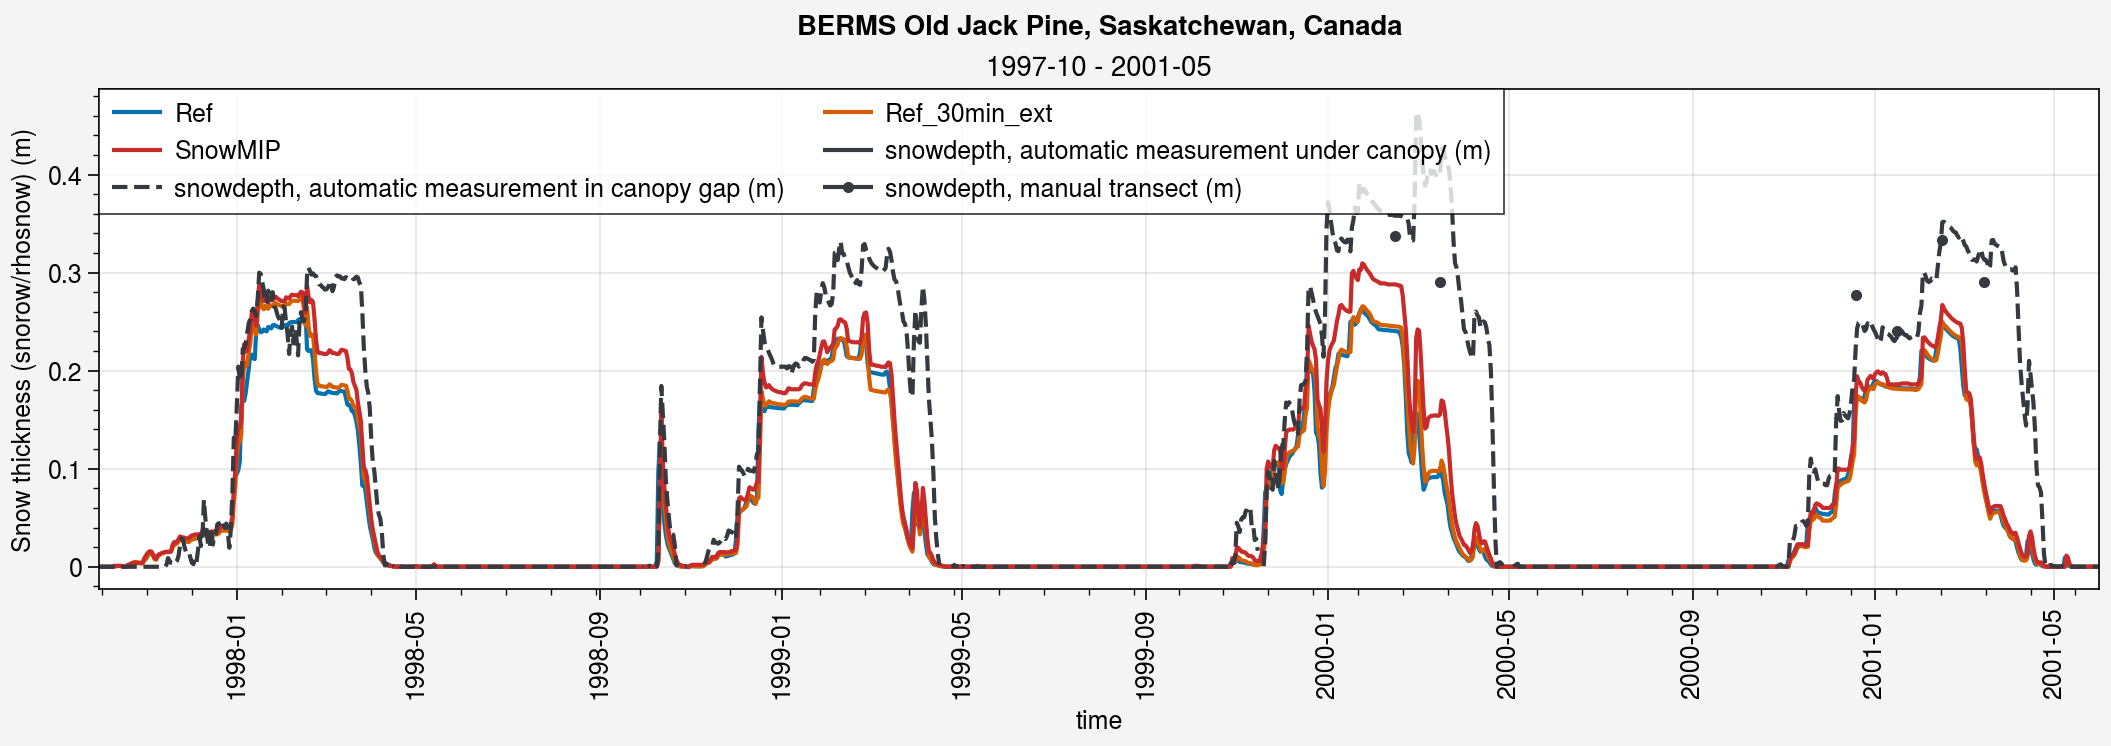

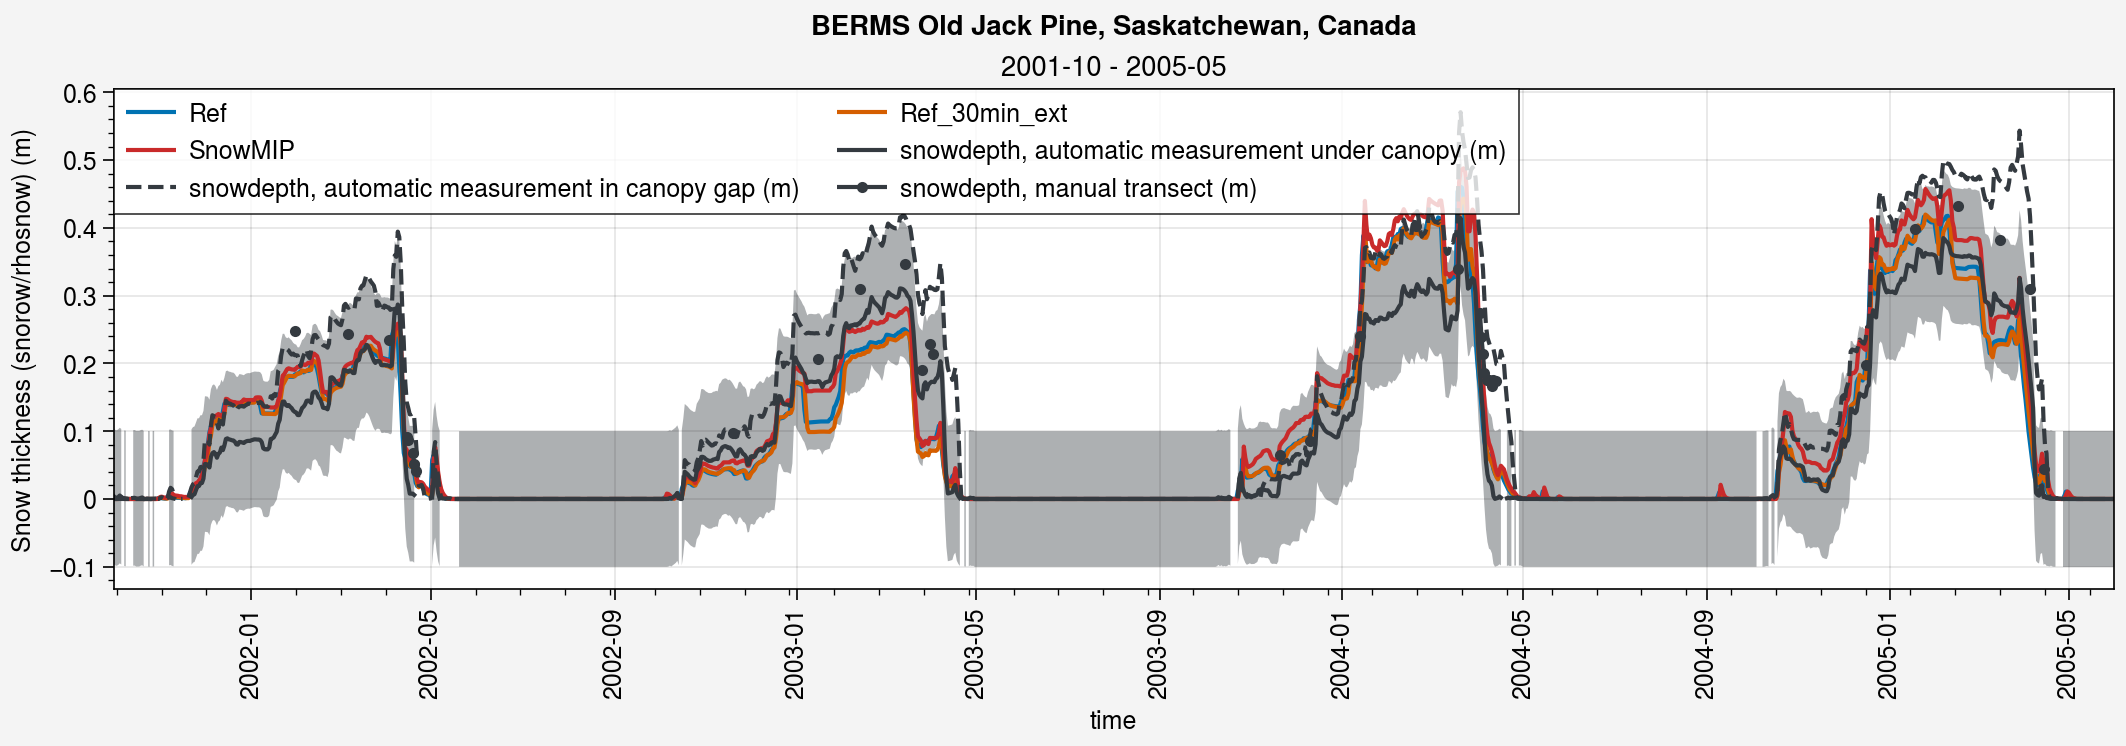

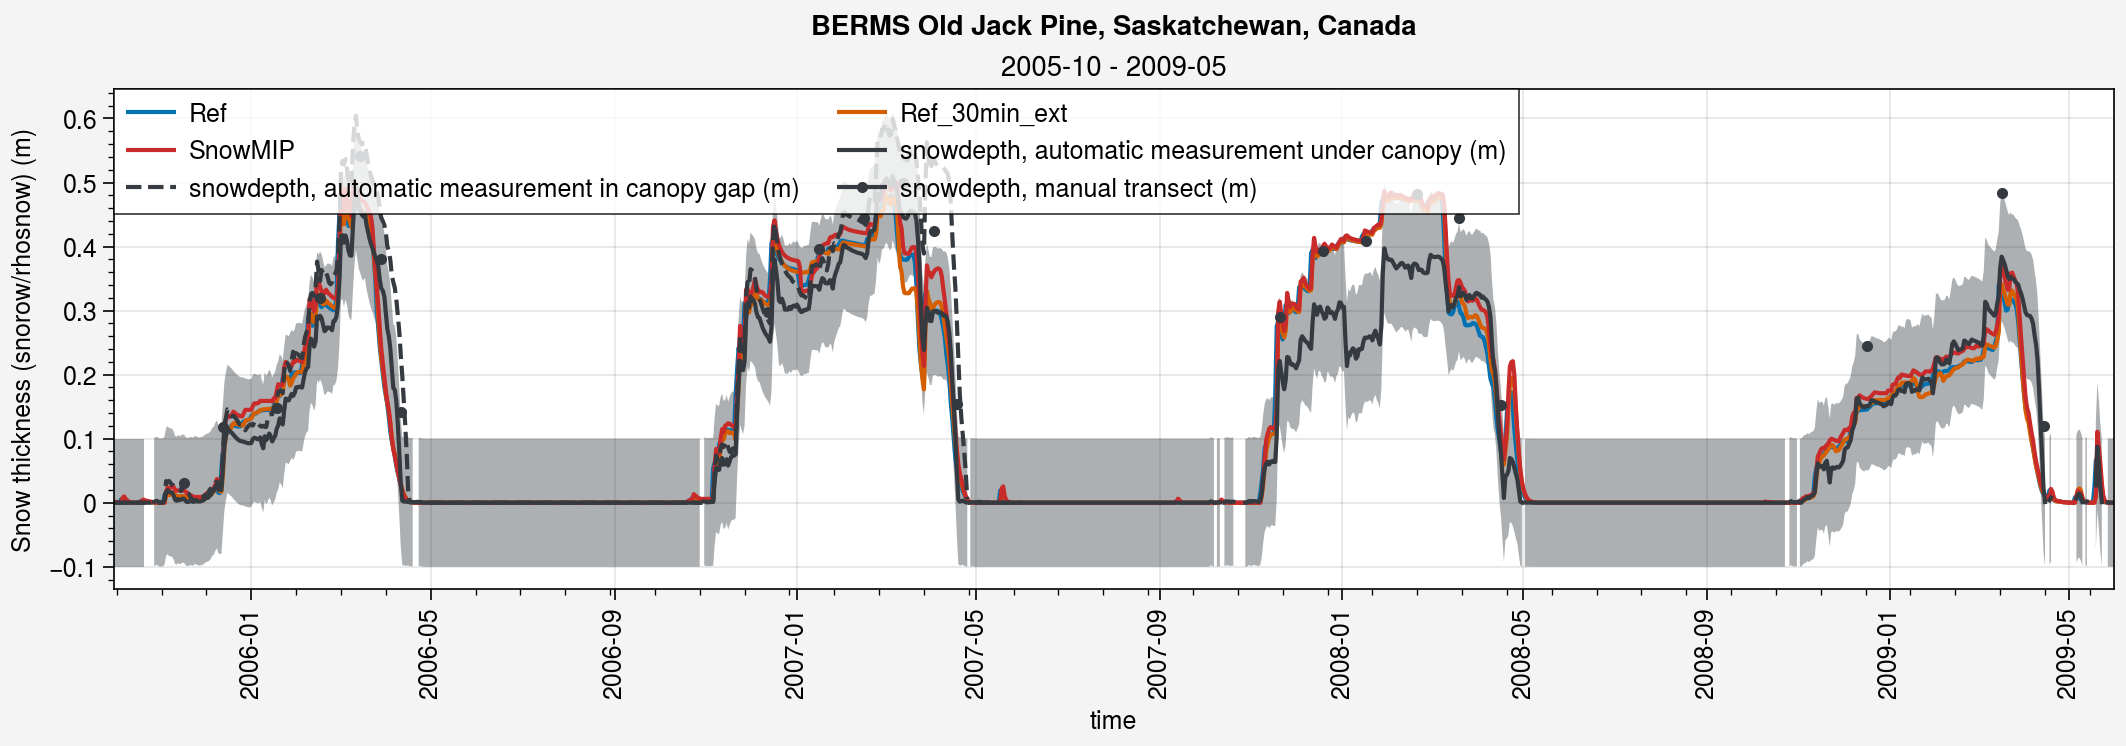

In [13]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-10',str(years[i*gap+gap])+'-05')
    else:
        period=slice(str(years[i*gap])+'-10',str(years[-1])+'-05')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.snd.sel(time=period), label=label)

    # SnowMIP
    axs[0].plot(ds_paul_d.snd.sel(time=period), label=label_paul, color='red9')
    
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_eval_menard2019.snd_can_auto.sel(time=period).values+0.1, axis=0),
        np.expand_dims(ds_d_eval_menard2019.snd_can_auto.sel(time=period).values-0.1, axis=0),), axis=0)
    axs[0].plot(ds_d_eval_menard2019.snd_can_auto.sel(time=period), shadedata=shadedata, color=color_obs)
    axs[0].plot(ds_d_eval_menard2019.snd_gap_auto.sel(time=period), color=color_obs, ls='--')
    axs[0].plot(ds_d_eval_menard2019.snd_man.sel(time=period), marker='.', color=color_obs)

    # Veg
    # axs[0].plot(ds_d_list[0].vegHeight.sel(time=period), label='vegHeight', color='k', alpha=0.5)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop)
    
    fig.suptitle(site_longname)


### SWE

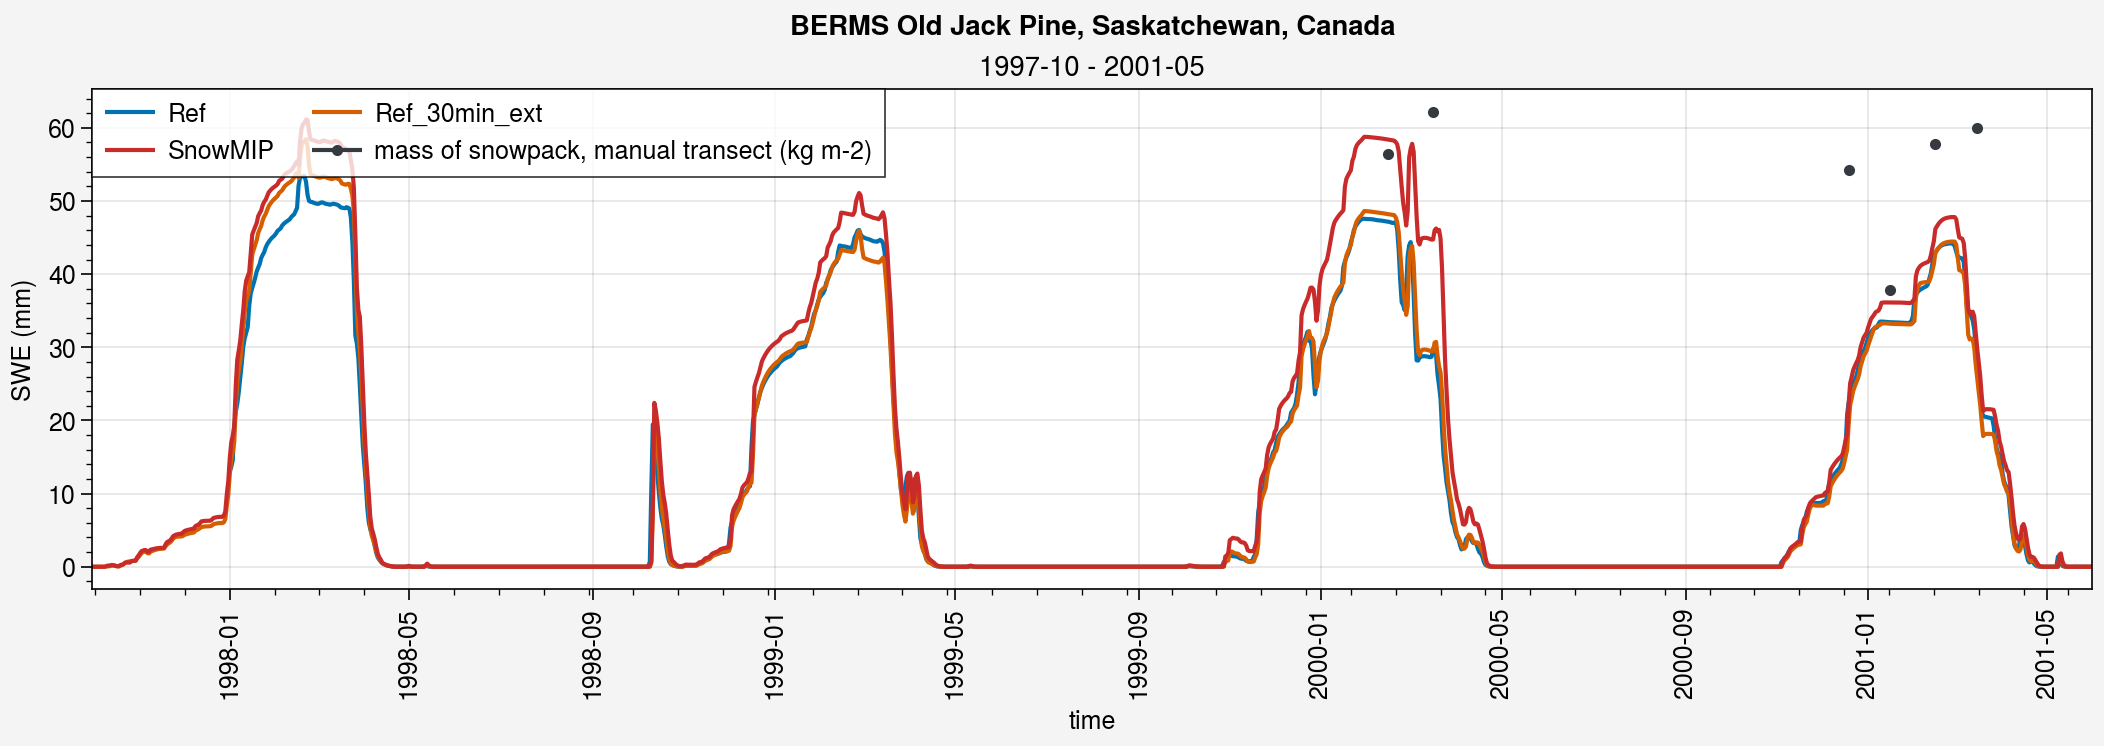

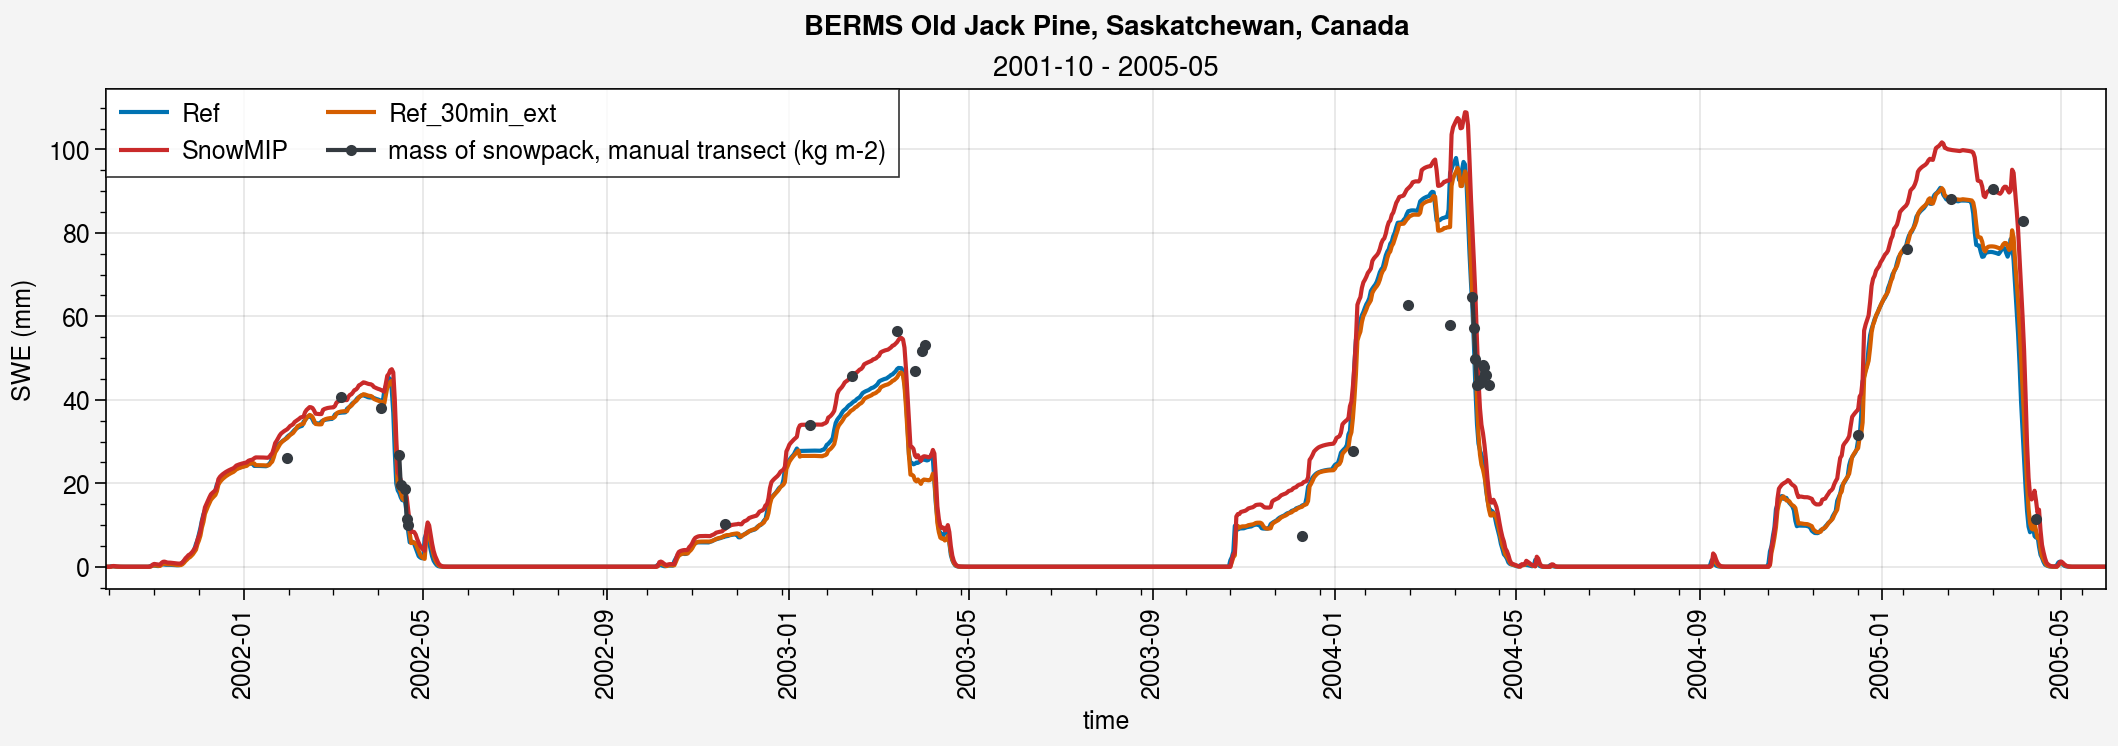

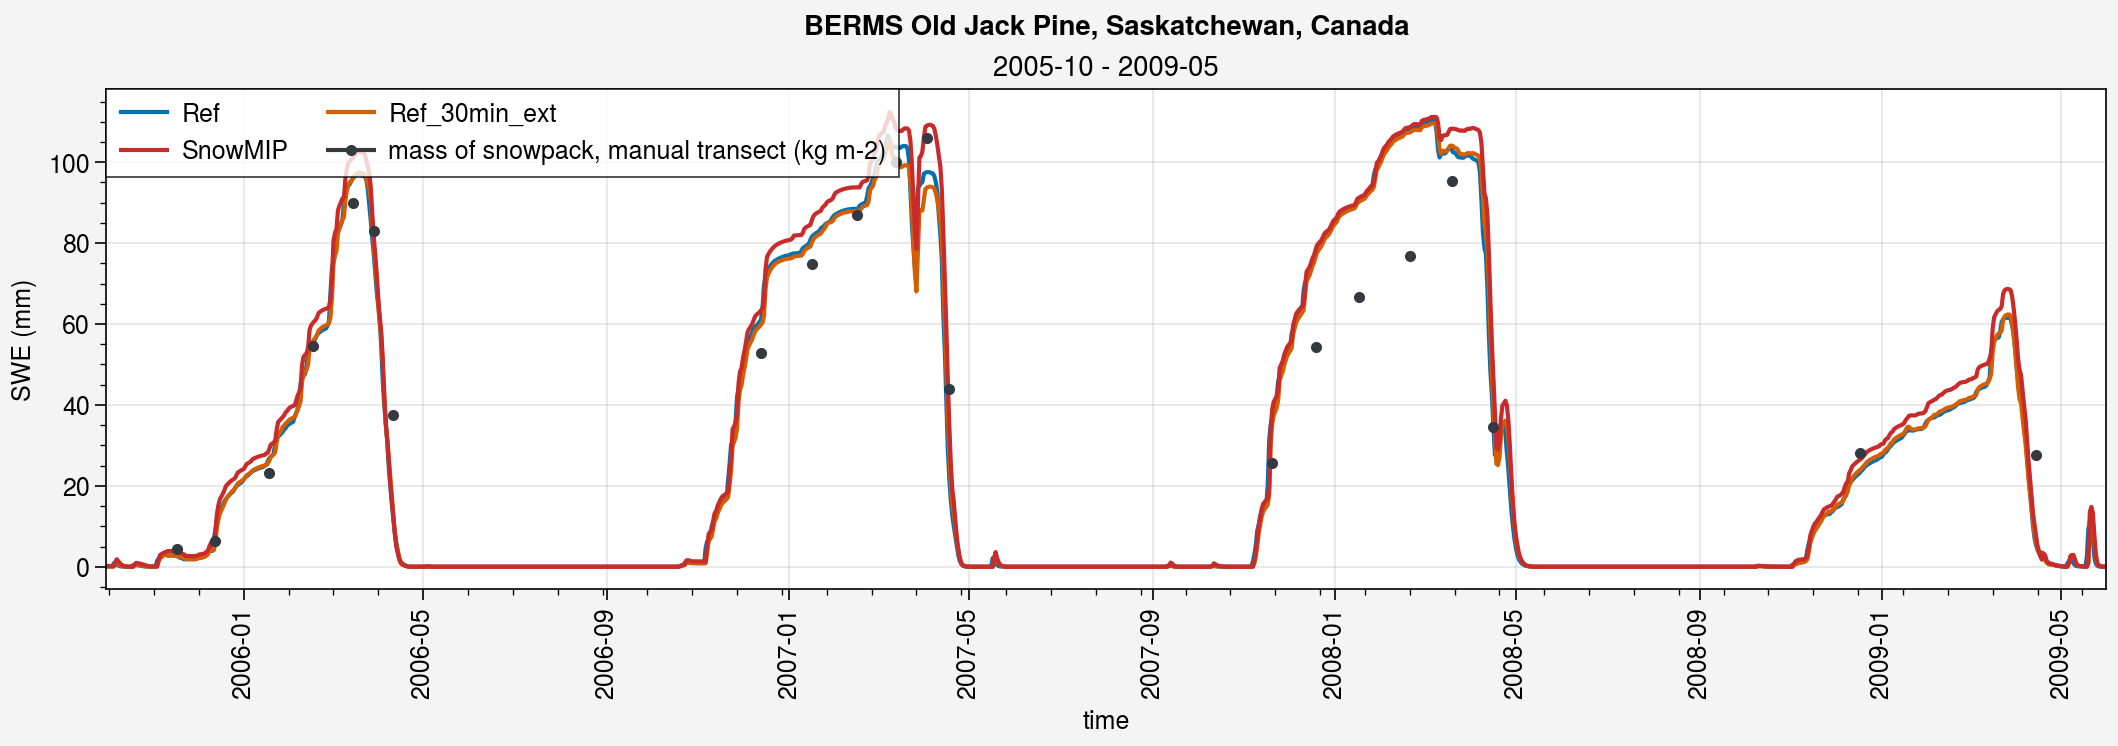

In [14]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-10',str(years[i*gap+gap])+'-05')
    else:
        period=slice(str(years[i*gap])+'-10',str(years[-1])+'-05')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.snw.sel(time=period), label=label)

    # SnowMIP
    axs[0].plot(ds_paul_d.snw.sel(time=period), label=label_paul, color='red9')
    
    # Obs
    # shadedata = np.concatenate((
    #     np.expand_dims(ds_d_eval_menard2019.snw_can_auto.sel(time=period).values+0.1, axis=0),
    #     np.expand_dims(ds_d_eval_menard2019.snw_can_auto.sel(time=period).values-0.1, axis=0),), axis=0)
    # axs[0].plot(ds_d_eval_menard2019.snw_can_auto.sel(time=period), shadedata=shadedata, color=color_obs)
    # axs[0].plot(ds_d_eval_menard2019.snw_gap_auto.sel(time=period), color=color_obs, ls='--')
    axs[0].plot(ds_d_eval_menard2019.snw_man.sel(time=period), marker='.', color=color_obs)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='SWE (mm)')
    
    fig.suptitle(site_longname)


### Albedo

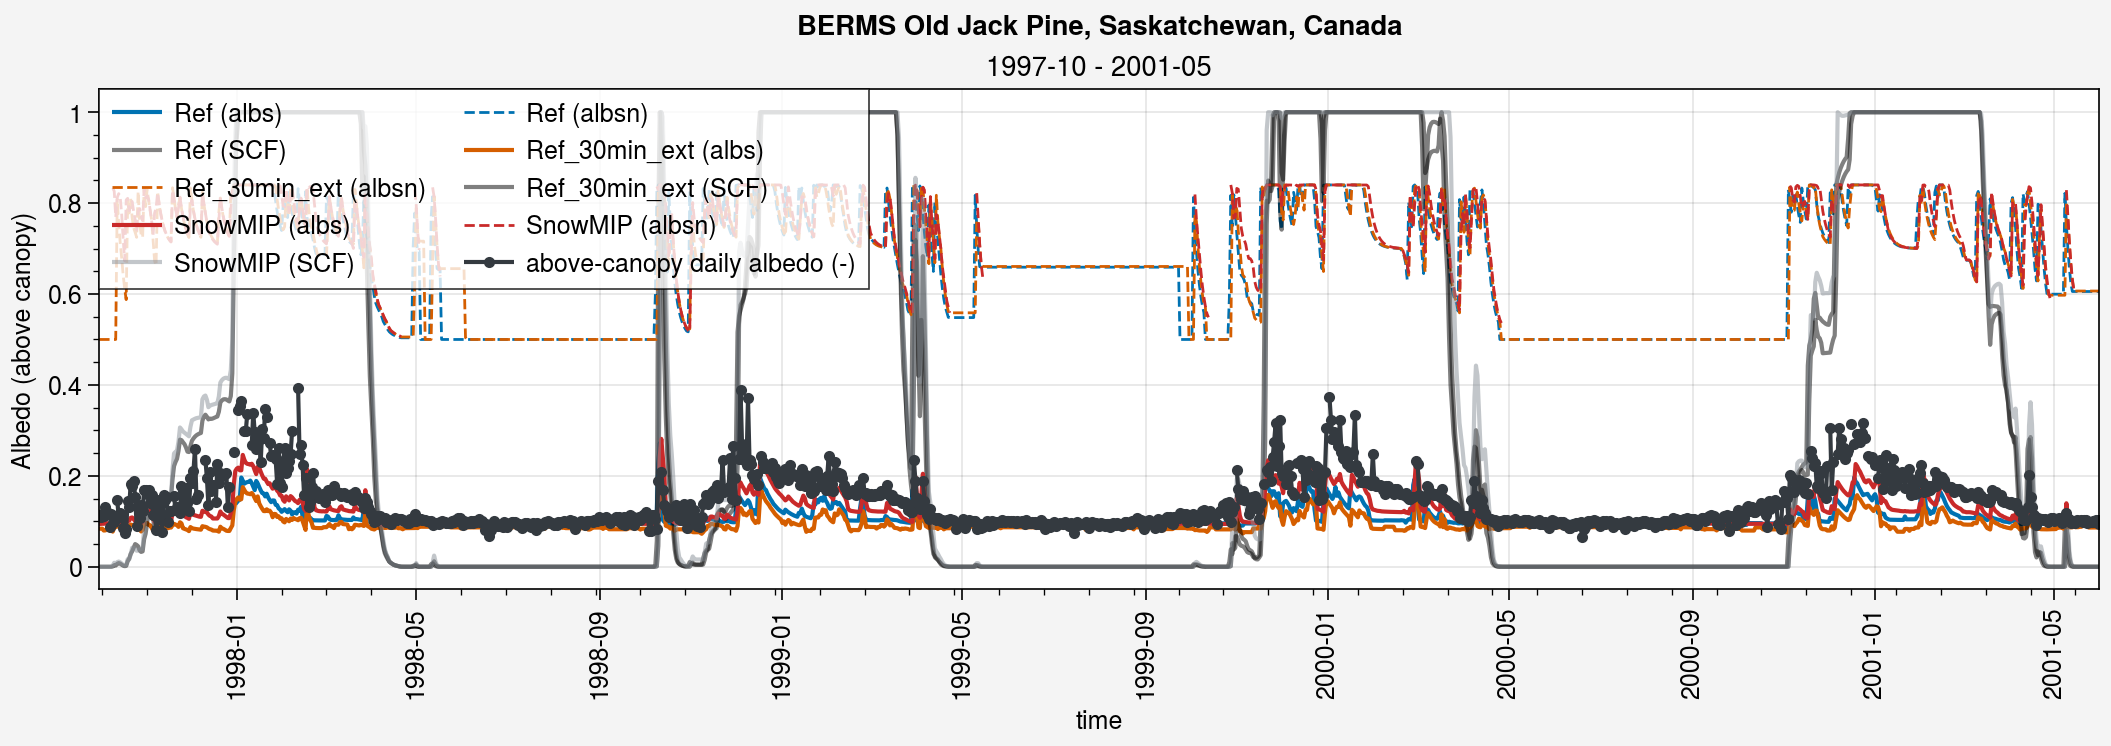

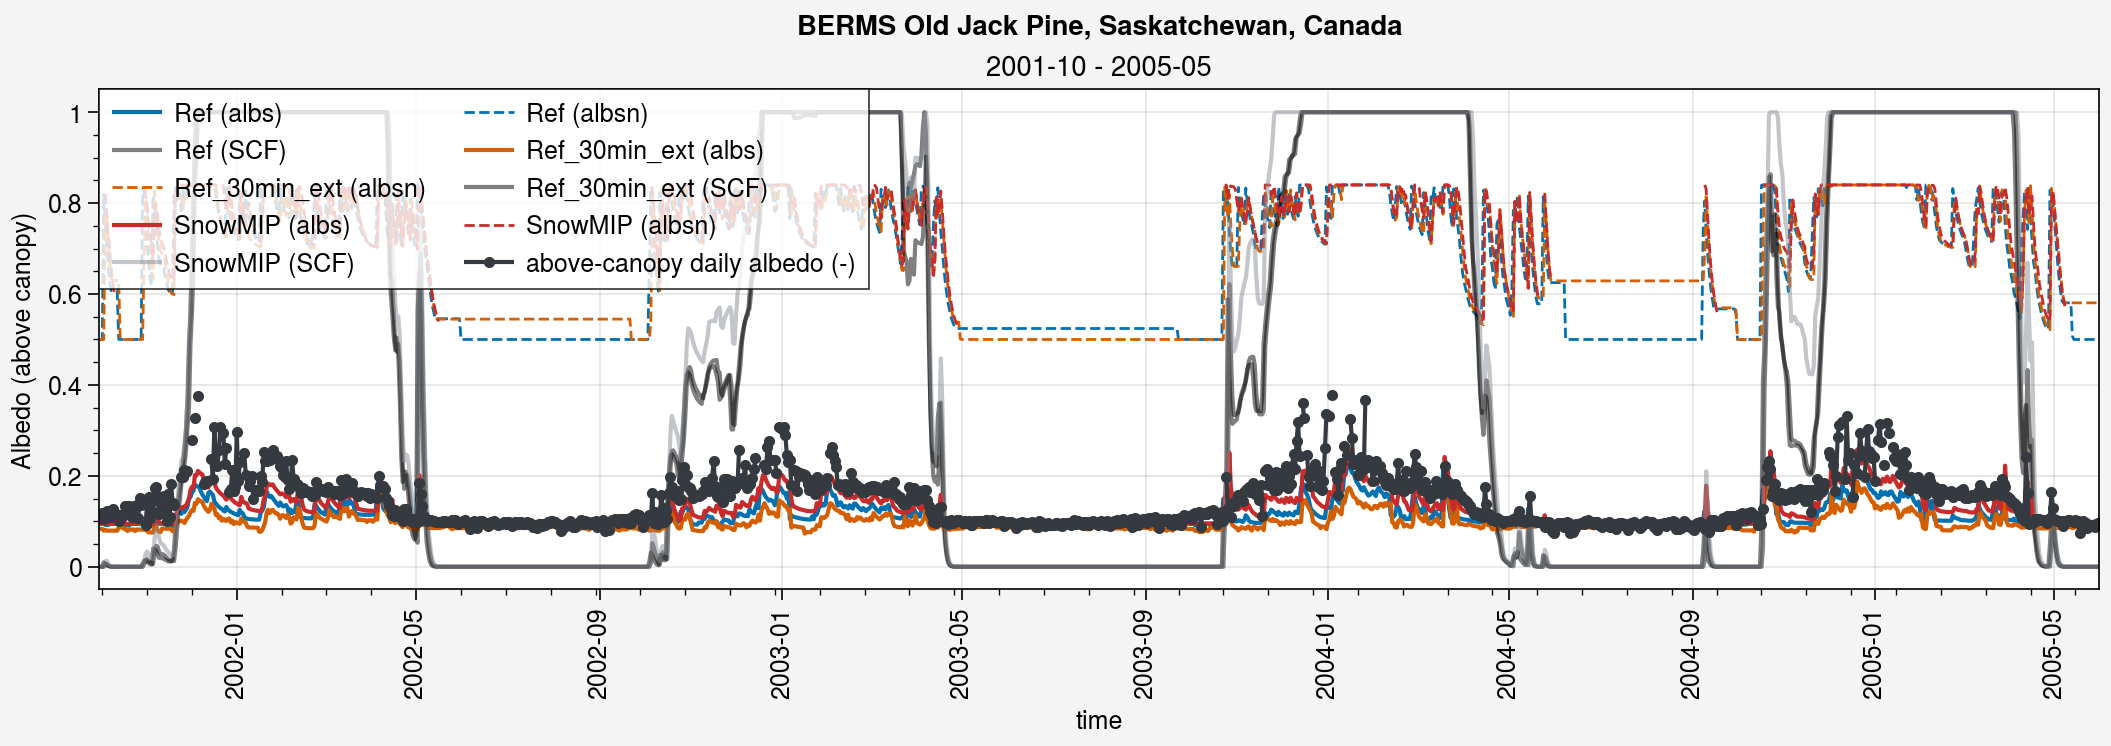

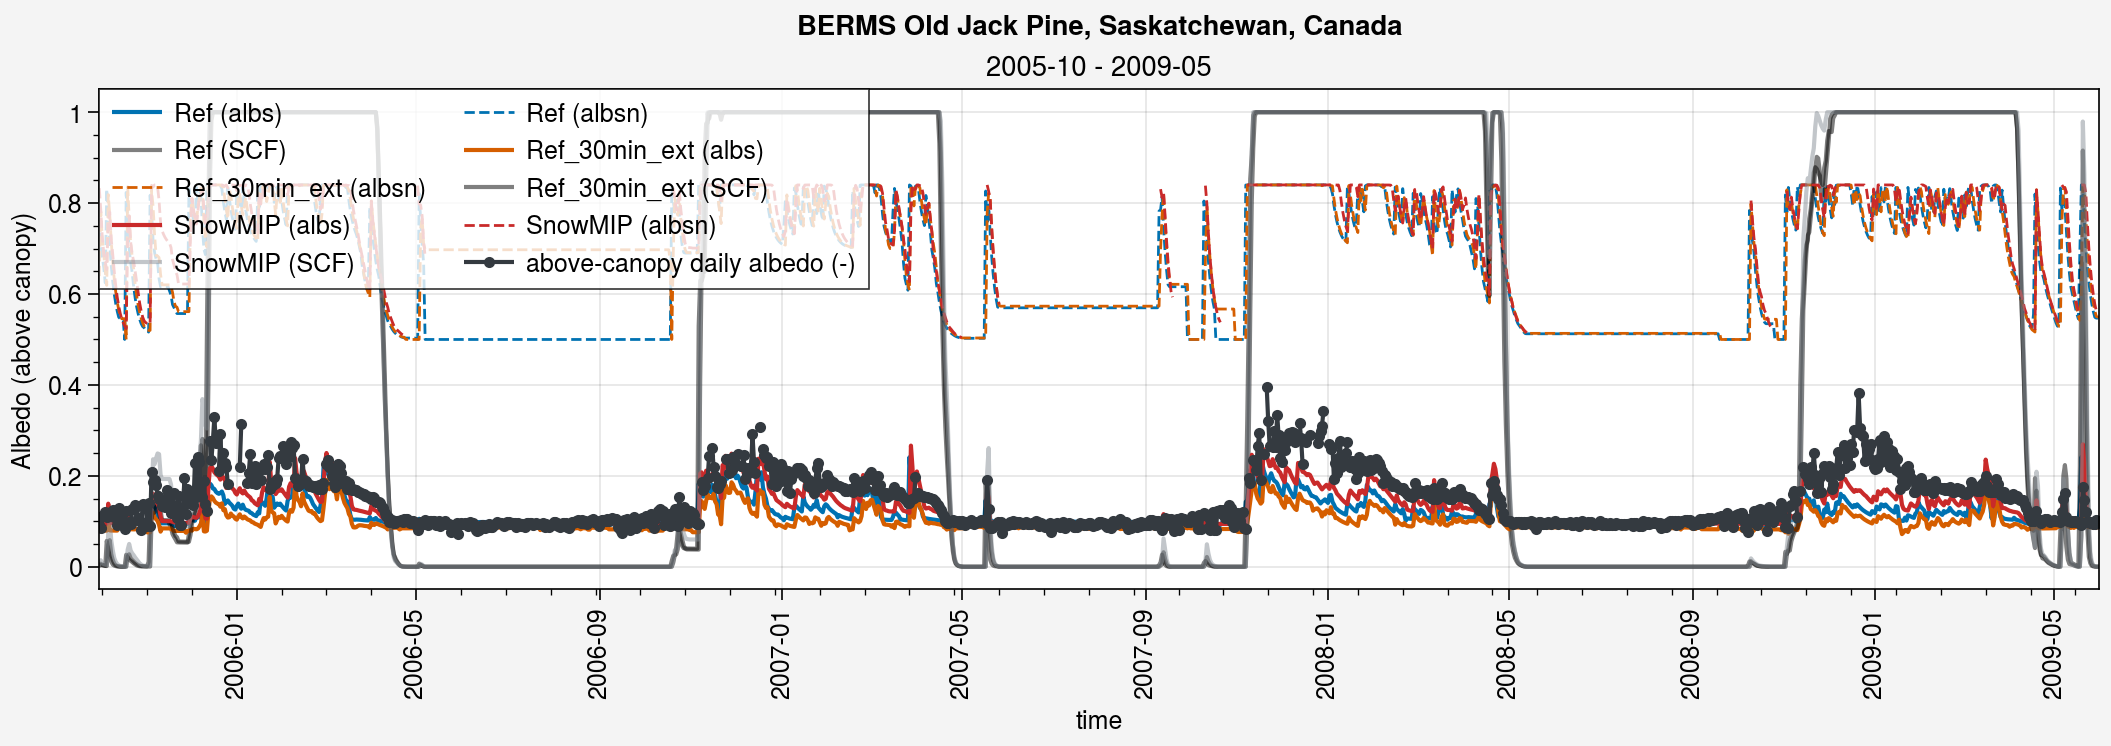

In [15]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-10',str(years[i*gap+gap])+'-05')
    else:
        period=slice(str(years[i*gap])+'-10',str(years[-1])+'-05')
    
    # Simus
    k = 0
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.albs.sel(time=period), label=label+' (albs)', color='C'+str(k))
        axs[0].plot(ds_d.albsn.sel(time=period), label=label+' (albsn)', color='C'+str(k), ls='--', lw=1)
        axs[0].plot(ds_d.snc.sel(time=period), label=label+' (SCF)', color='k', alpha=0.5)
        
        k+=1

    # SnowMIP
    axs[0].plot(ds_paul_d.albs.sel(time=period), label=label_paul+' (albs)', color='red9')
    axs[0].plot(ds_paul_d.albsn.sel(time=period), label=label_paul+' (albsn)', color='red9', ls='--', lw=1)
    axs[0].plot(ds_paul_d.snc.sel(time=period), label=label_paul+' (SCF)', color='gray6', alpha=0.5)
    
    # Obs
    axs[0].plot(ds_d_eval_menard2019.albs.sel(time=period), marker='.', color=color_obs)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Albedo (above canopy)')
    
    fig.suptitle(site_longname)


### Surface Temperature

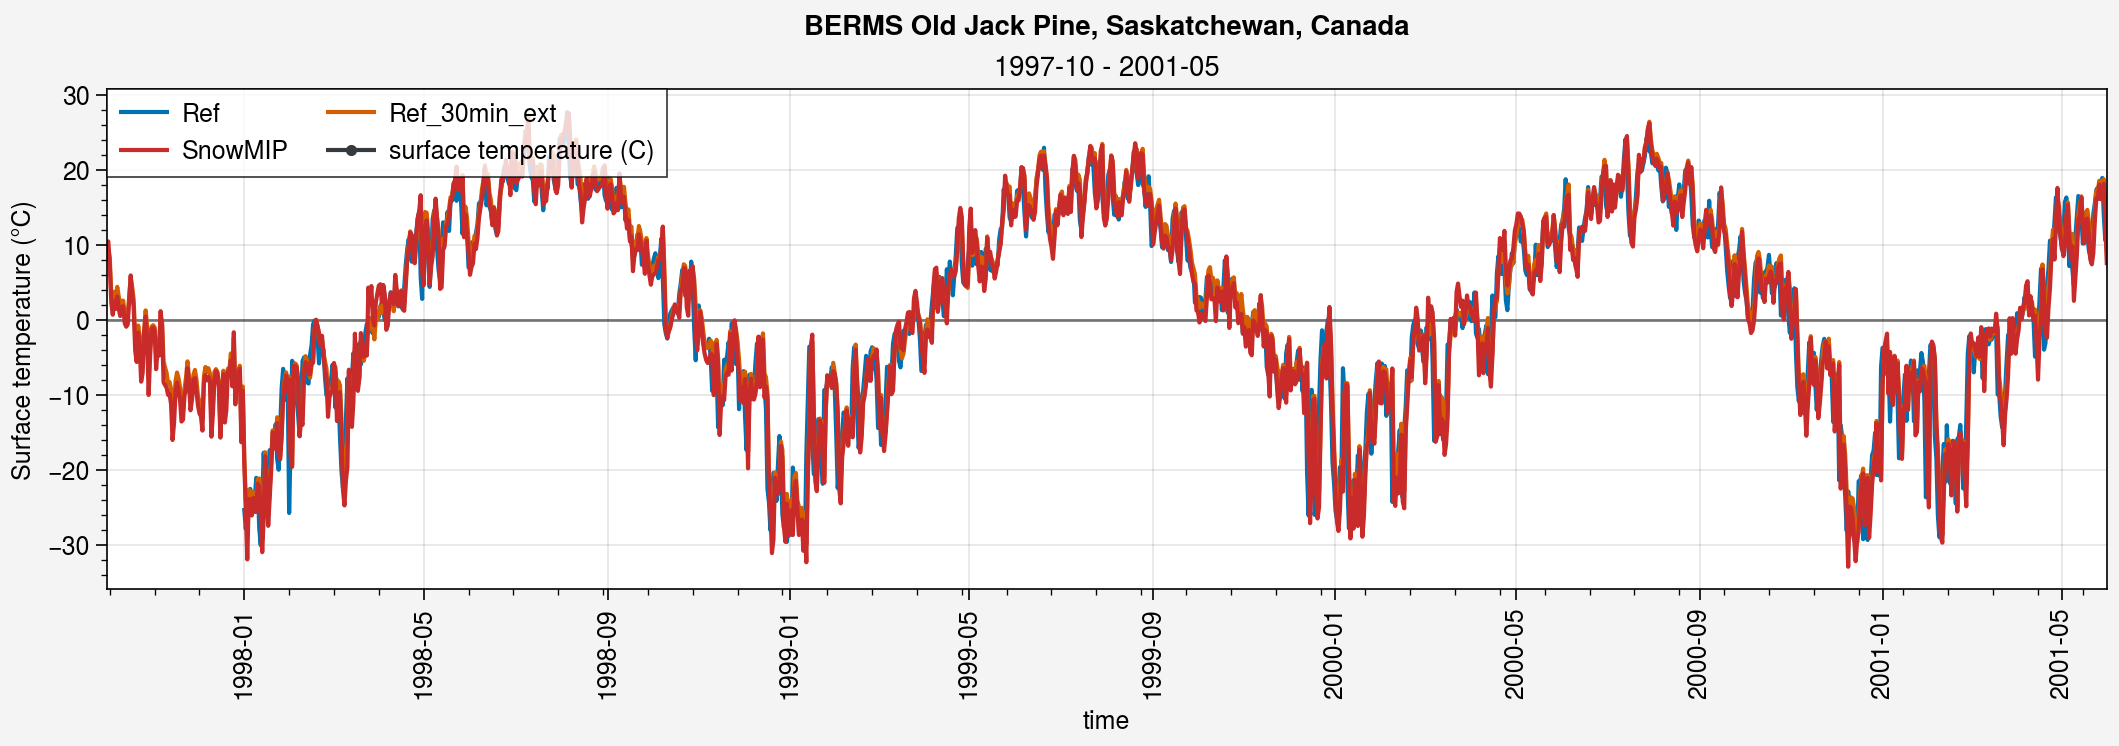

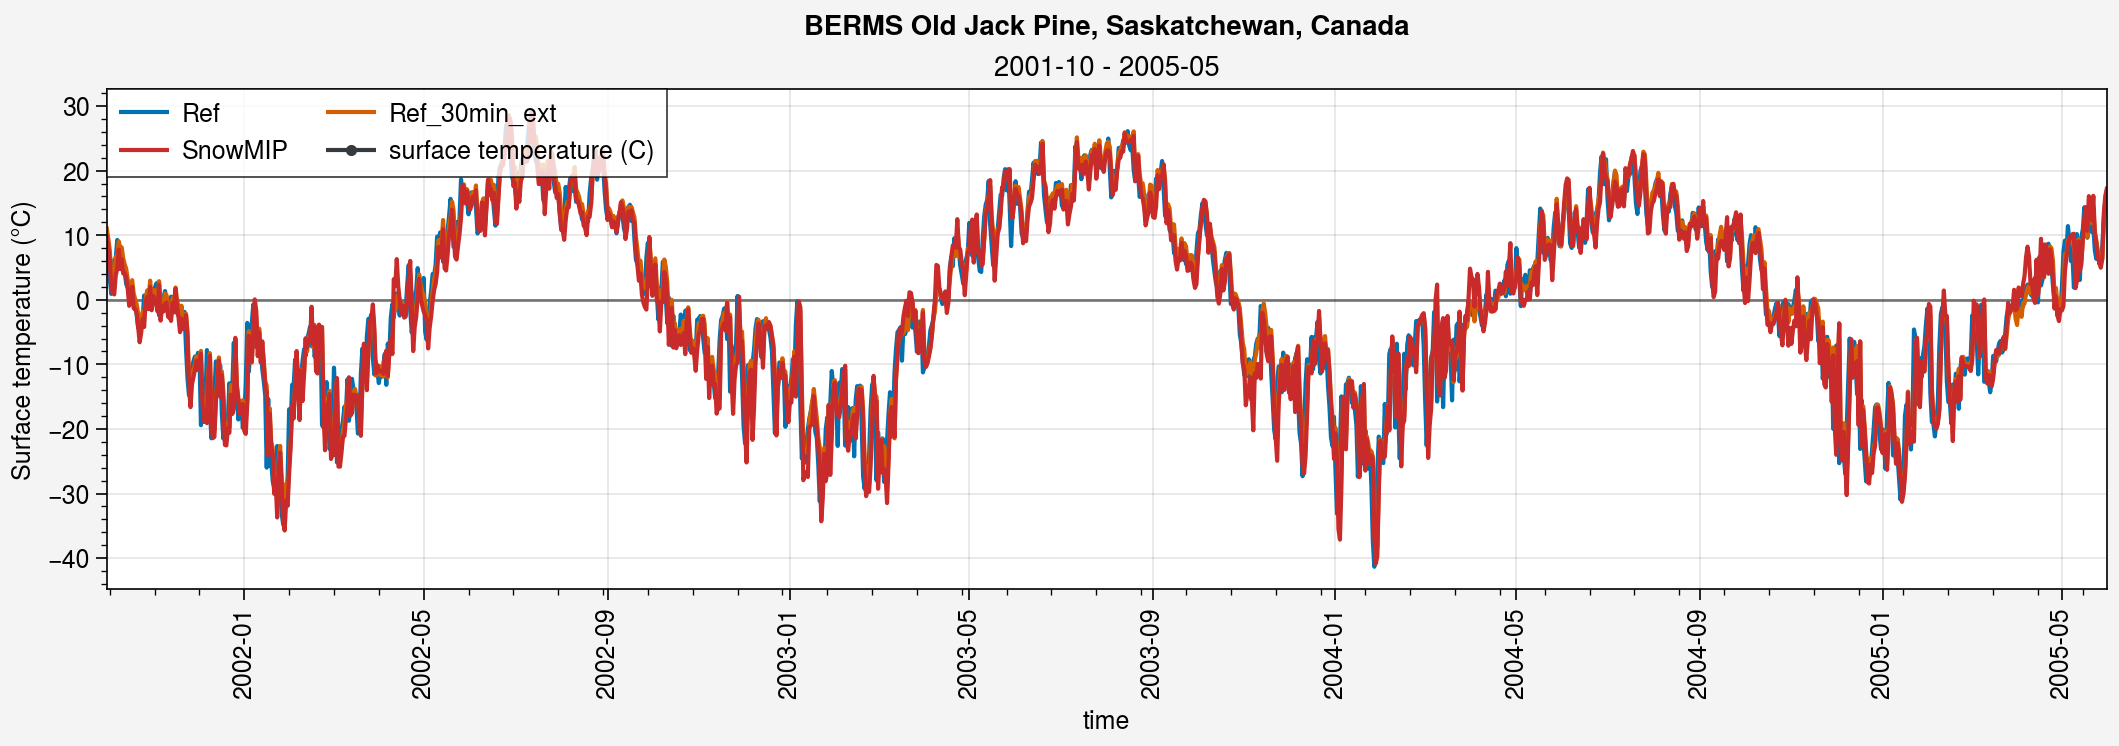

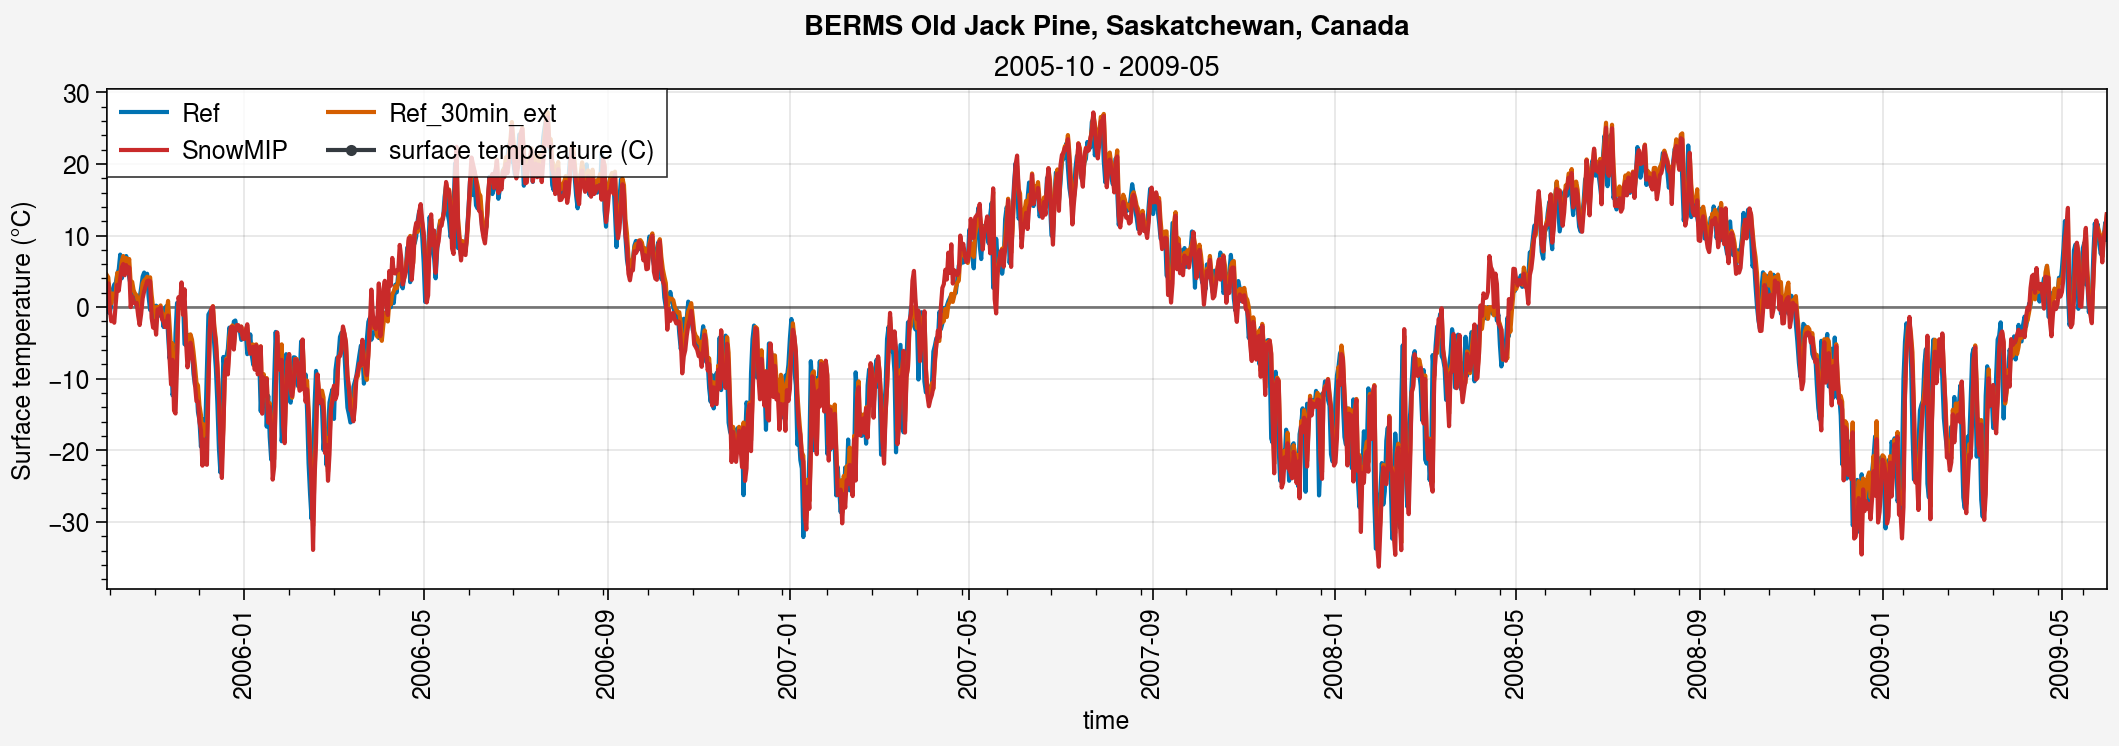

In [16]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-10',str(years[i*gap+gap])+'-05')
    else:
        period=slice(str(years[i*gap])+'-10',str(years[-1])+'-05')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.ts.sel(time=period)-273.15, label=label)

    # SnowMIP
    axs[0].plot(ds_paul_d.ts.sel(time=period)-273.15, label=label_paul, color='red9')
    
    # Obs
    axs[0].plot(ds_d_eval_menard2019.ts.sel(time=period), marker='.', color=color_obs)
    axs[0].hlines(0, ds_d.ts.sel(time=period).time[0], ds_d.ts.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Surface temperature (°C)')
    
    fig.suptitle(site_longname)


### Soil Temperature

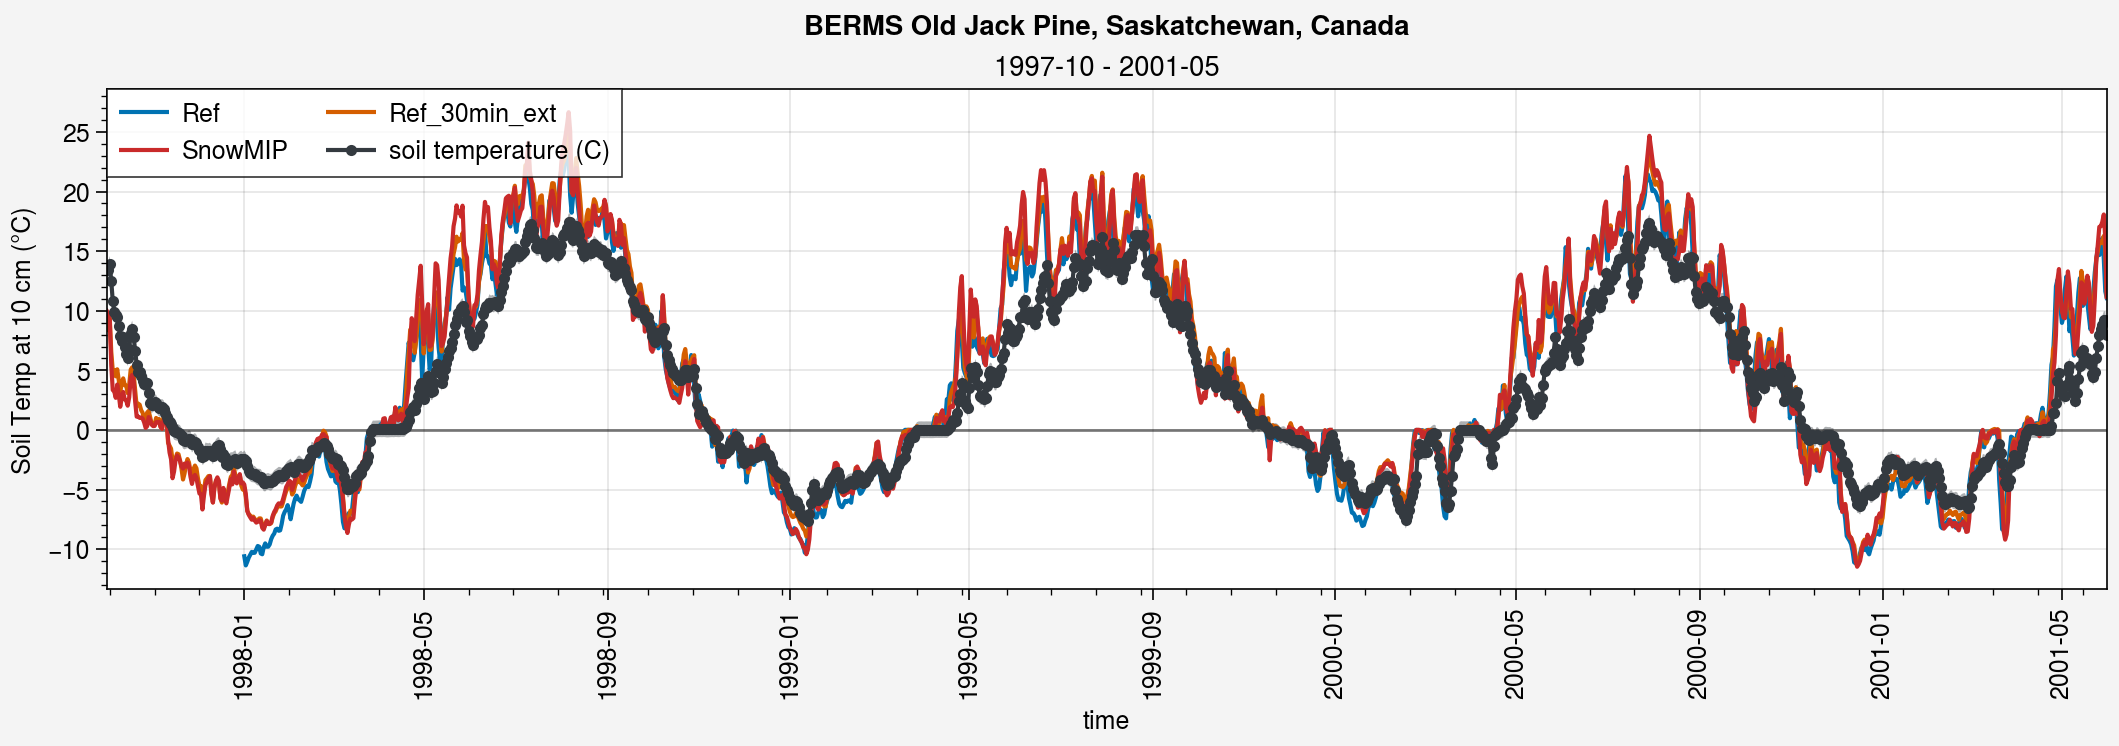

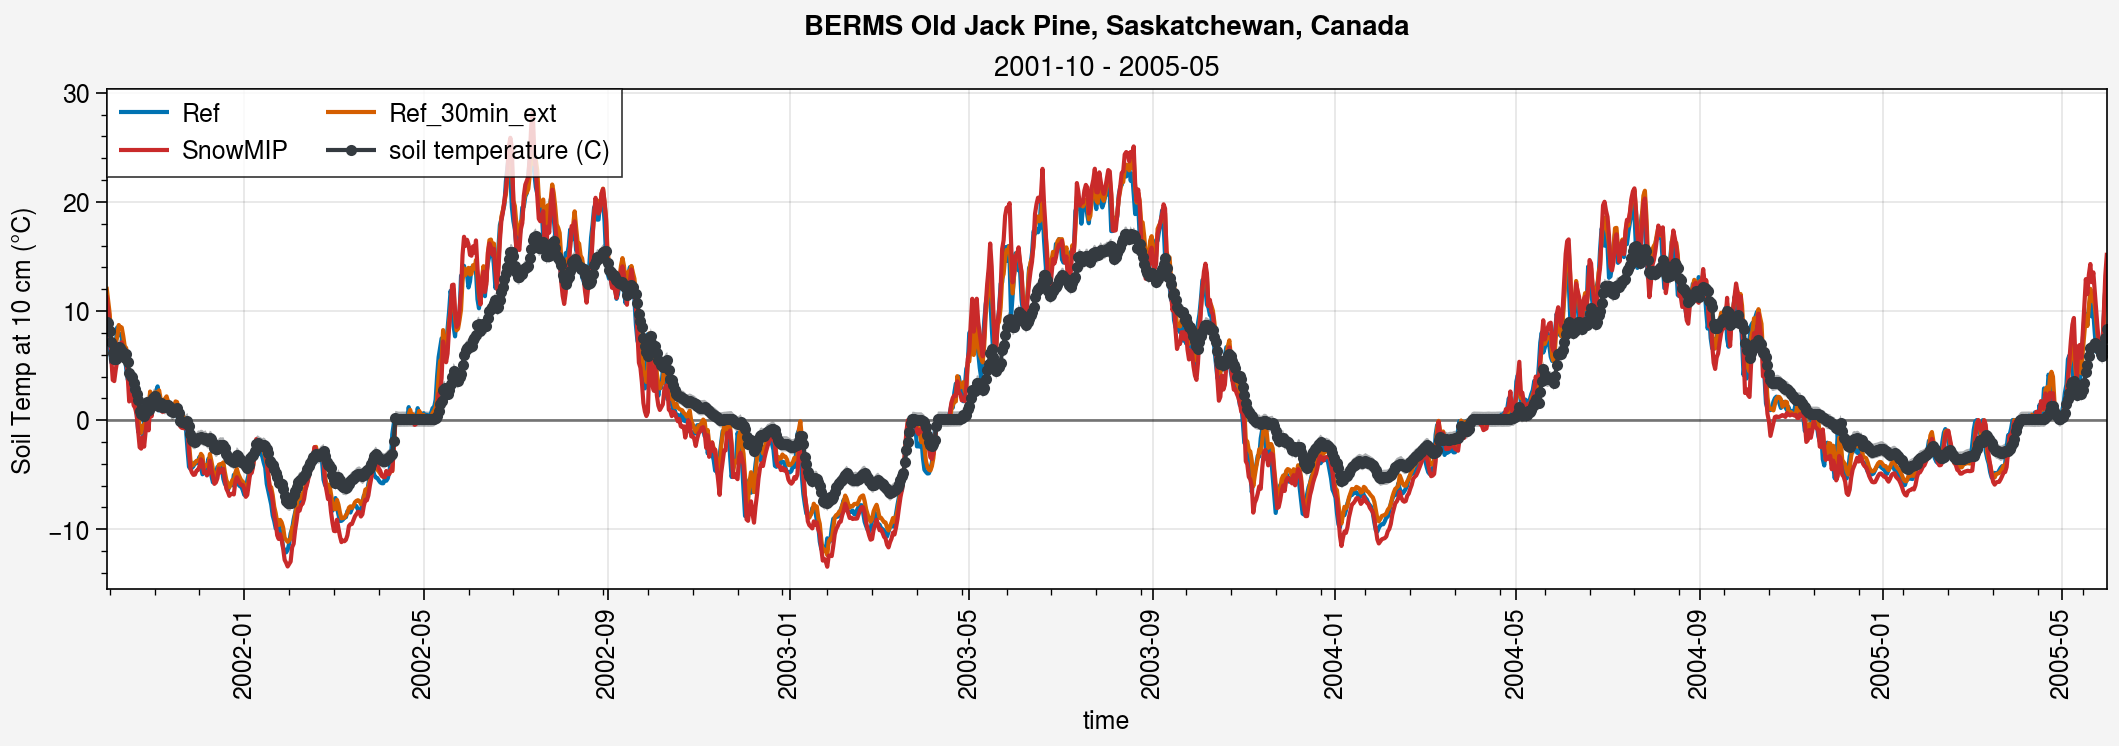

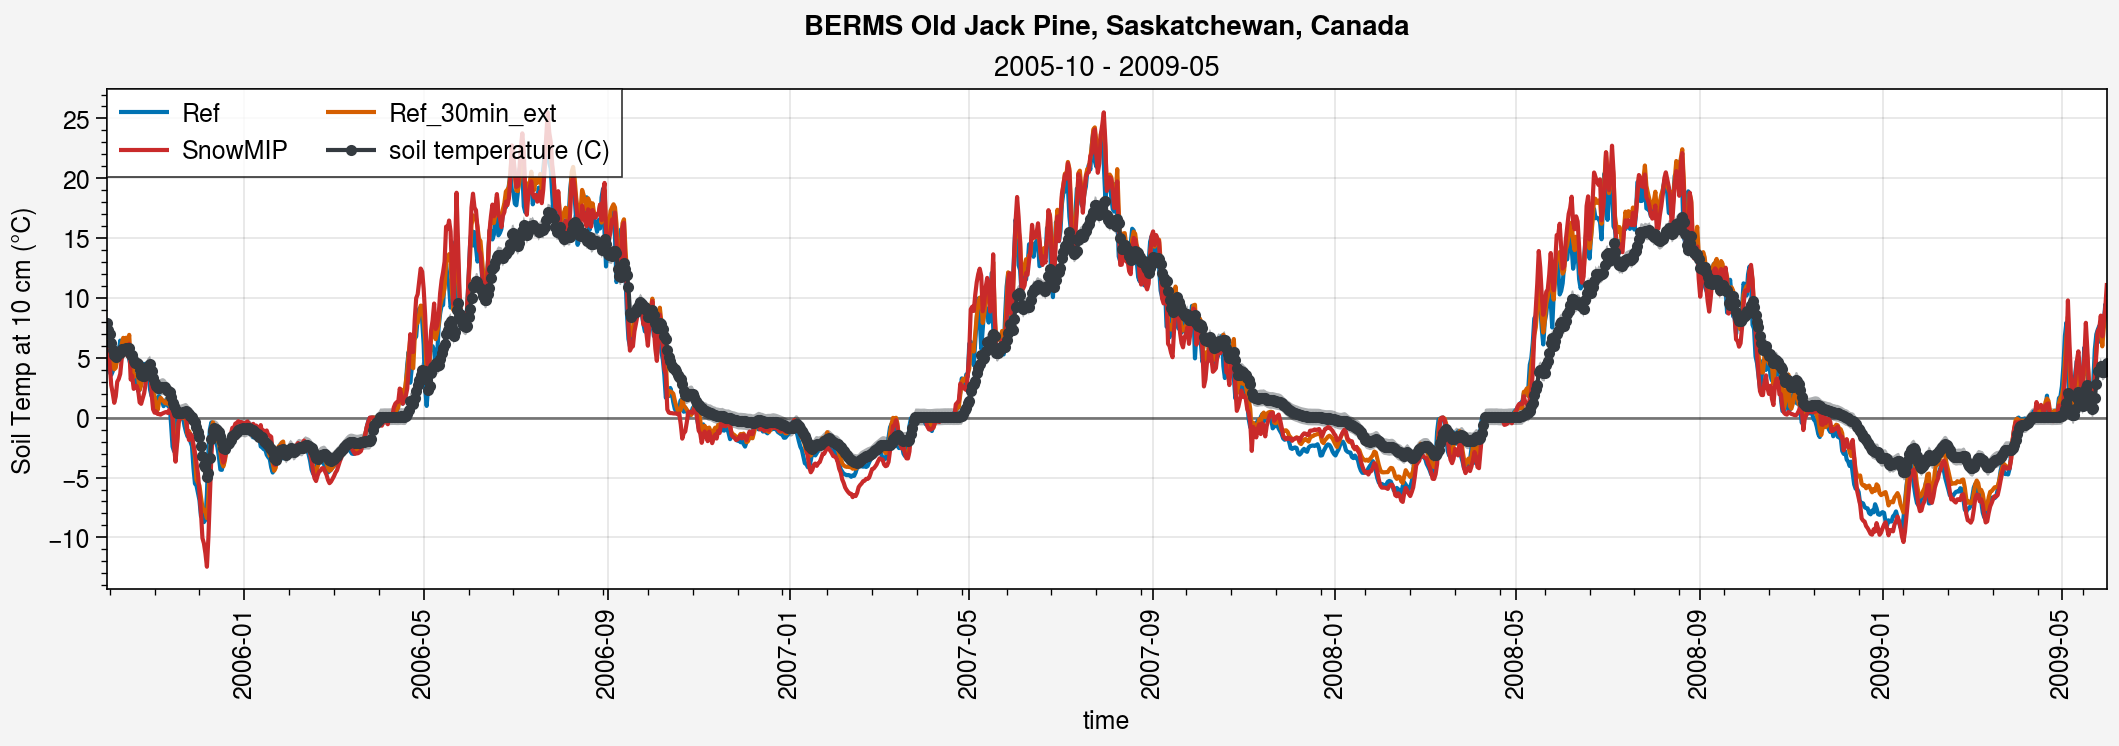

In [17]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-10',str(years[i*gap+gap])+'-05')
    else:
        period=slice(str(years[i*gap])+'-10',str(years[-1])+'-05')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        # axs[0].plot(((ds_d.tsl.sel(time=period, layer=1)+ds_d.tsl.sel(time=period, layer=2))/2)-273.15, label=label)
        # axs[0].plot(((ds_d.tsl.sel(time=period).isel(layer=0)+ds_d.tsl.sel(time=period).isel(layer=1))/2)-273.15, label=label)
        axs[0].plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_eval_menard2019.sdepth.values).sel(layer=0.1)-273.15, label=label)
    # axs[0].plot(((0.6*ds_paul_d['tsl:1'].sel(time=period)+0.4*ds_paul_d['tsl:2'].sel(time=period)))-273.15, label=label_paul, color='red9')
    axs[0].plot(ds_paul_d.tsl.sel(time=period).interp(layer=ds_d_eval_menard2019.sdepth.values).sel(layer=0.1)-273.15, label=label_paul, color='red9')
        
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.1)+0.7, axis=0),
        np.expand_dims(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.1)-0.7, axis=0),), axis=0)
    axs[0].plot(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.1), shadedata=shadedata, marker='.', color=color_obs)
    
    axs[0].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Soil Temp at 10 cm (°C)')
    
    fig.suptitle(site_longname)


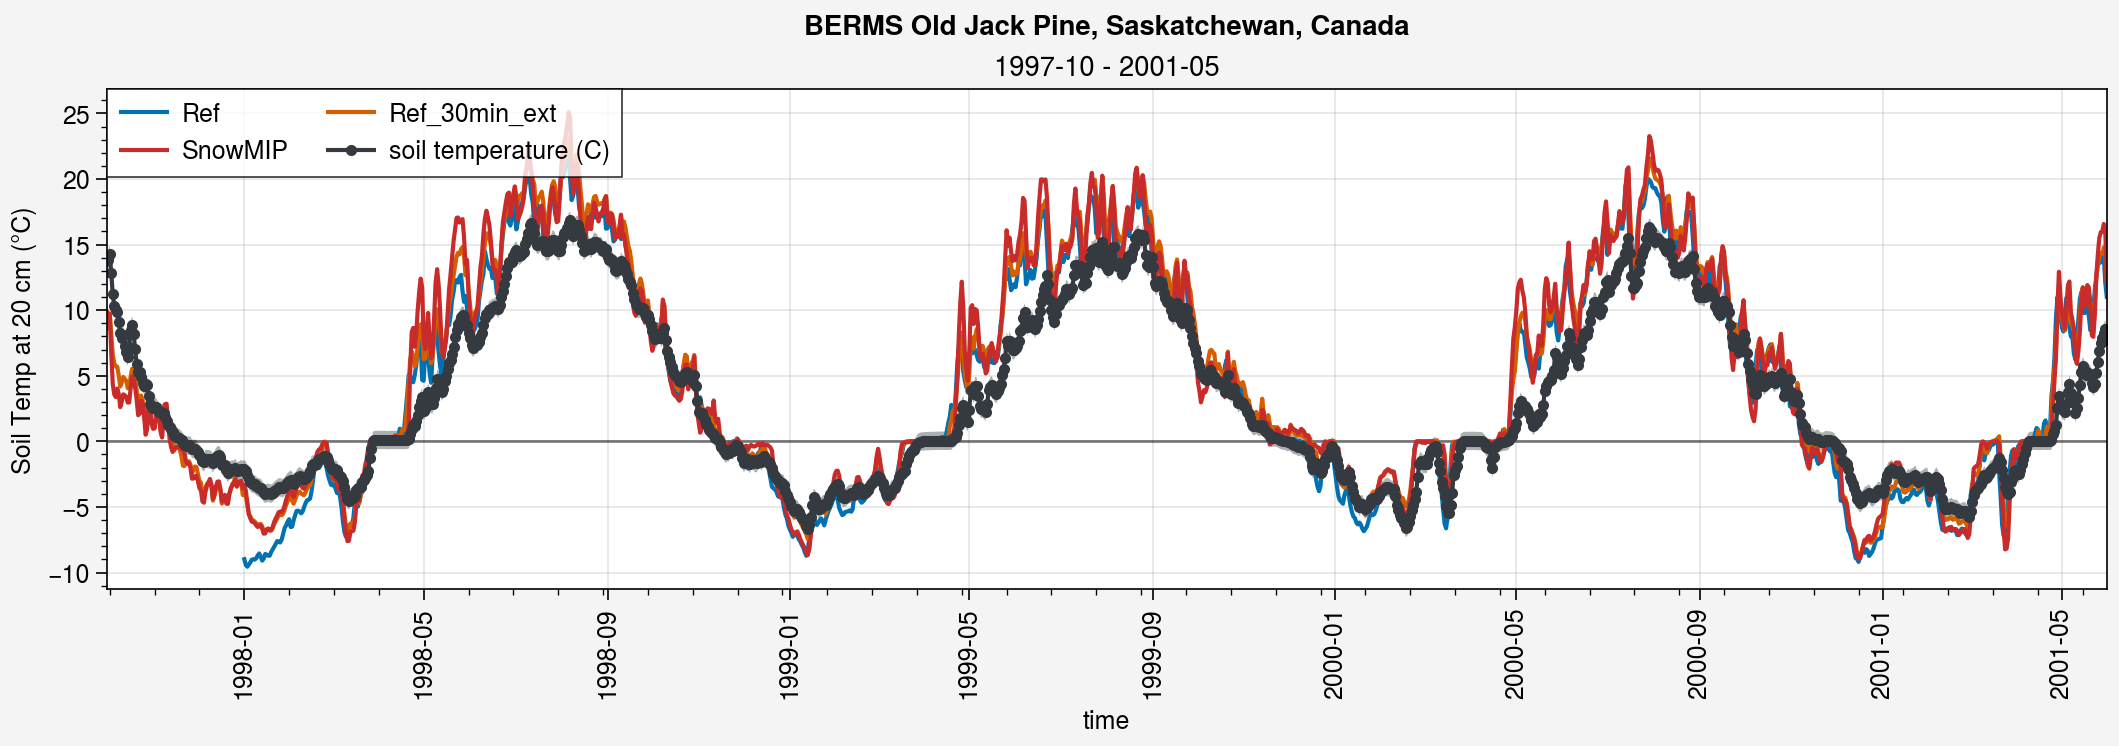

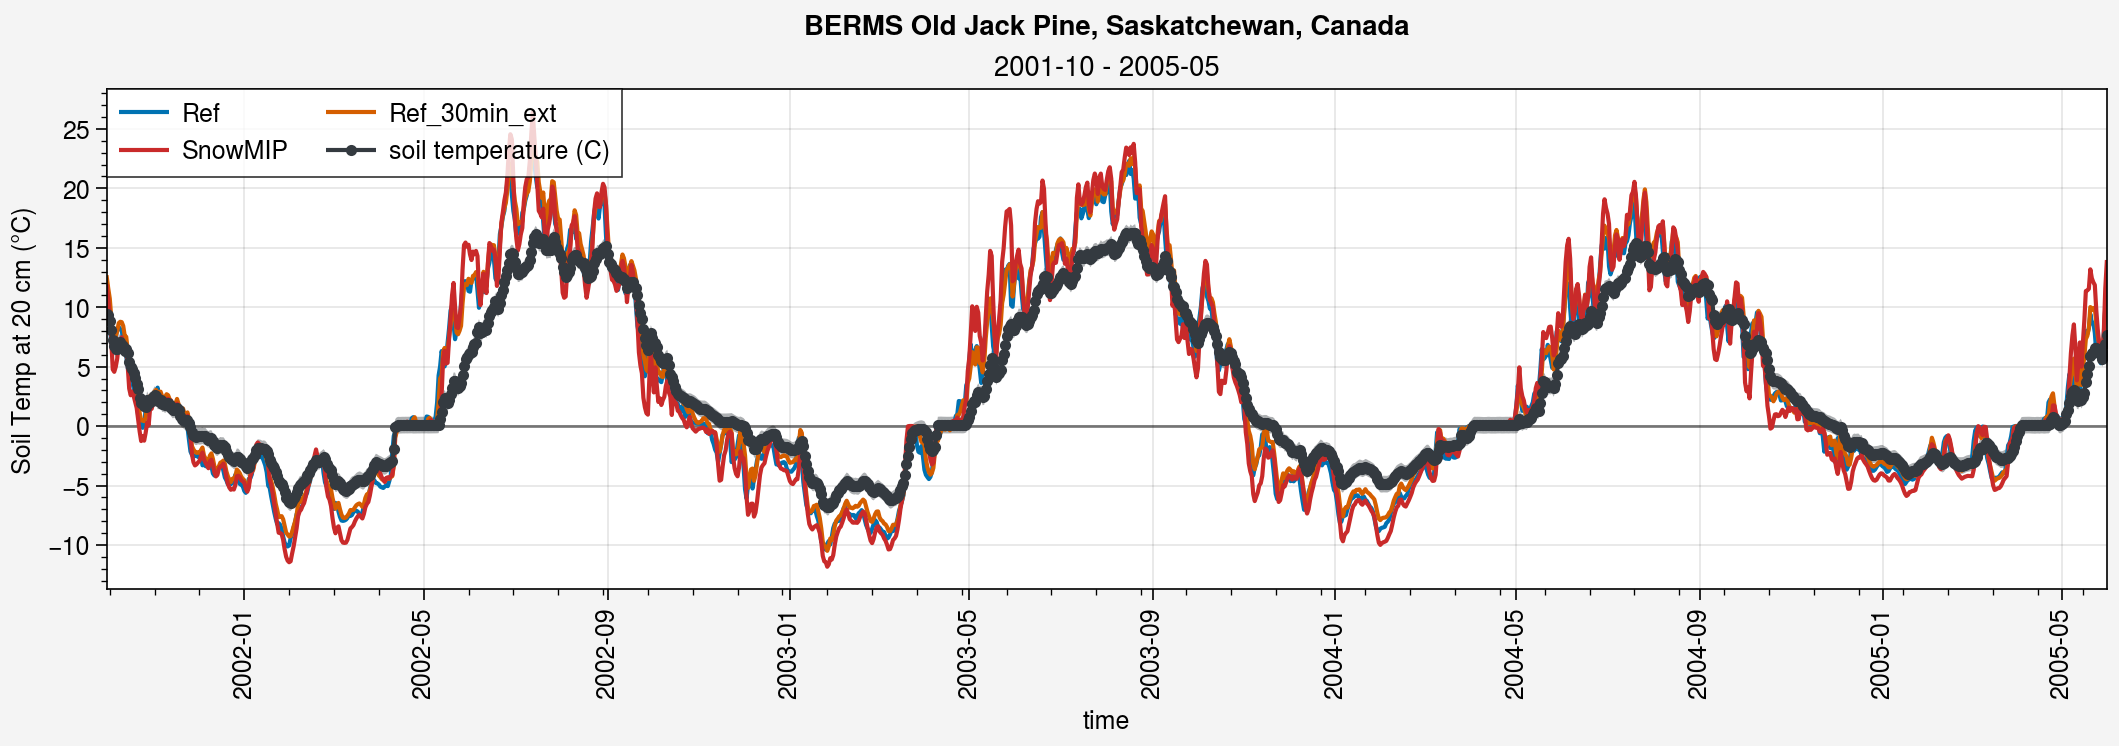

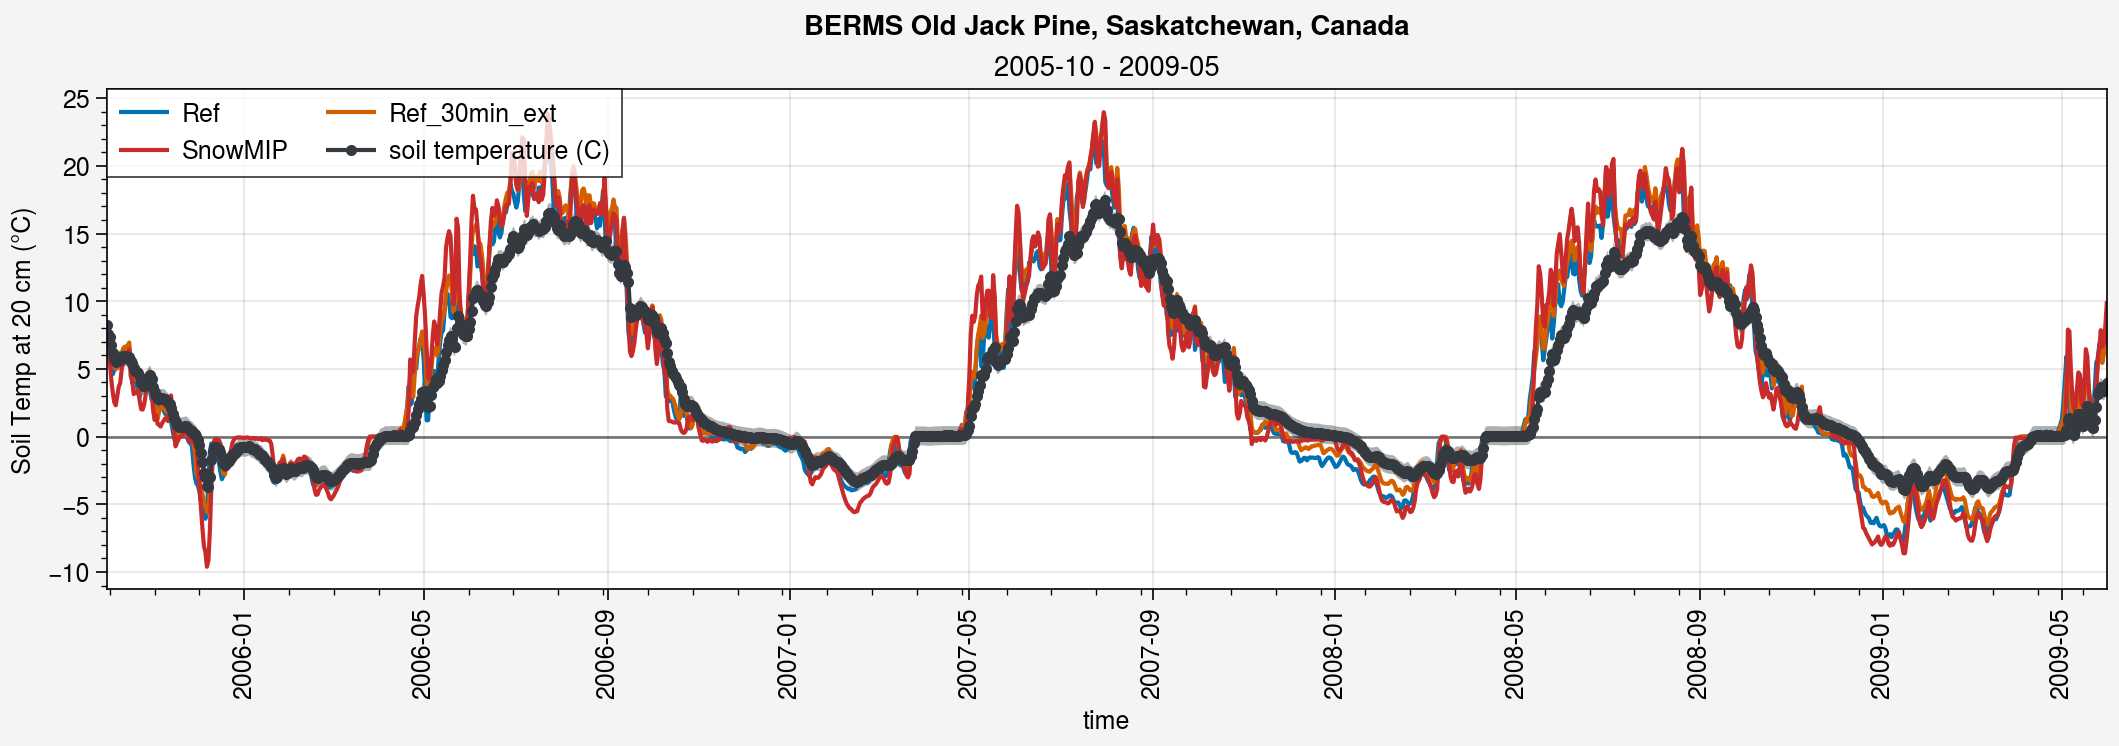

In [18]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-10',str(years[i*gap+gap])+'-05')
    else:
        period=slice(str(years[i*gap])+'-10',str(years[-1])+'-05')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        # axs[0].plot(((ds_d.tsl.sel(time=period, layer=2)+ds_d.tsl.sel(time=period, layer=3))/2)-273.15, label=label)
        # axs[0].plot(((ds_d.tsl.sel(time=period).isel(layer=1)+ds_d.tsl.sel(time=period).isel(layer=2))/2)-273.15, label=label)
        axs[0].plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_eval_menard2019.sdepth.values).sel(layer=0.2)-273.15, label=label)
    # axs[0].plot(ds_paul_d['tsl:2'].sel(time=period)-273.15, label=label_paul, color='red9')
    axs[0].plot(ds_paul_d.tsl.sel(time=period).interp(layer=ds_d_eval_menard2019.sdepth.values).sel(layer=0.2)-273.15, label=label_paul, color='red9')
    
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.2)+0.7, axis=0),
        np.expand_dims(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.2)-0.7, axis=0),), axis=0)
    axs[0].plot(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.2), shadedata=shadedata, marker='.', color=color_obs)
    
    axs[0].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Soil Temp at 20 cm (°C)')
    
    fig.suptitle(site_longname)


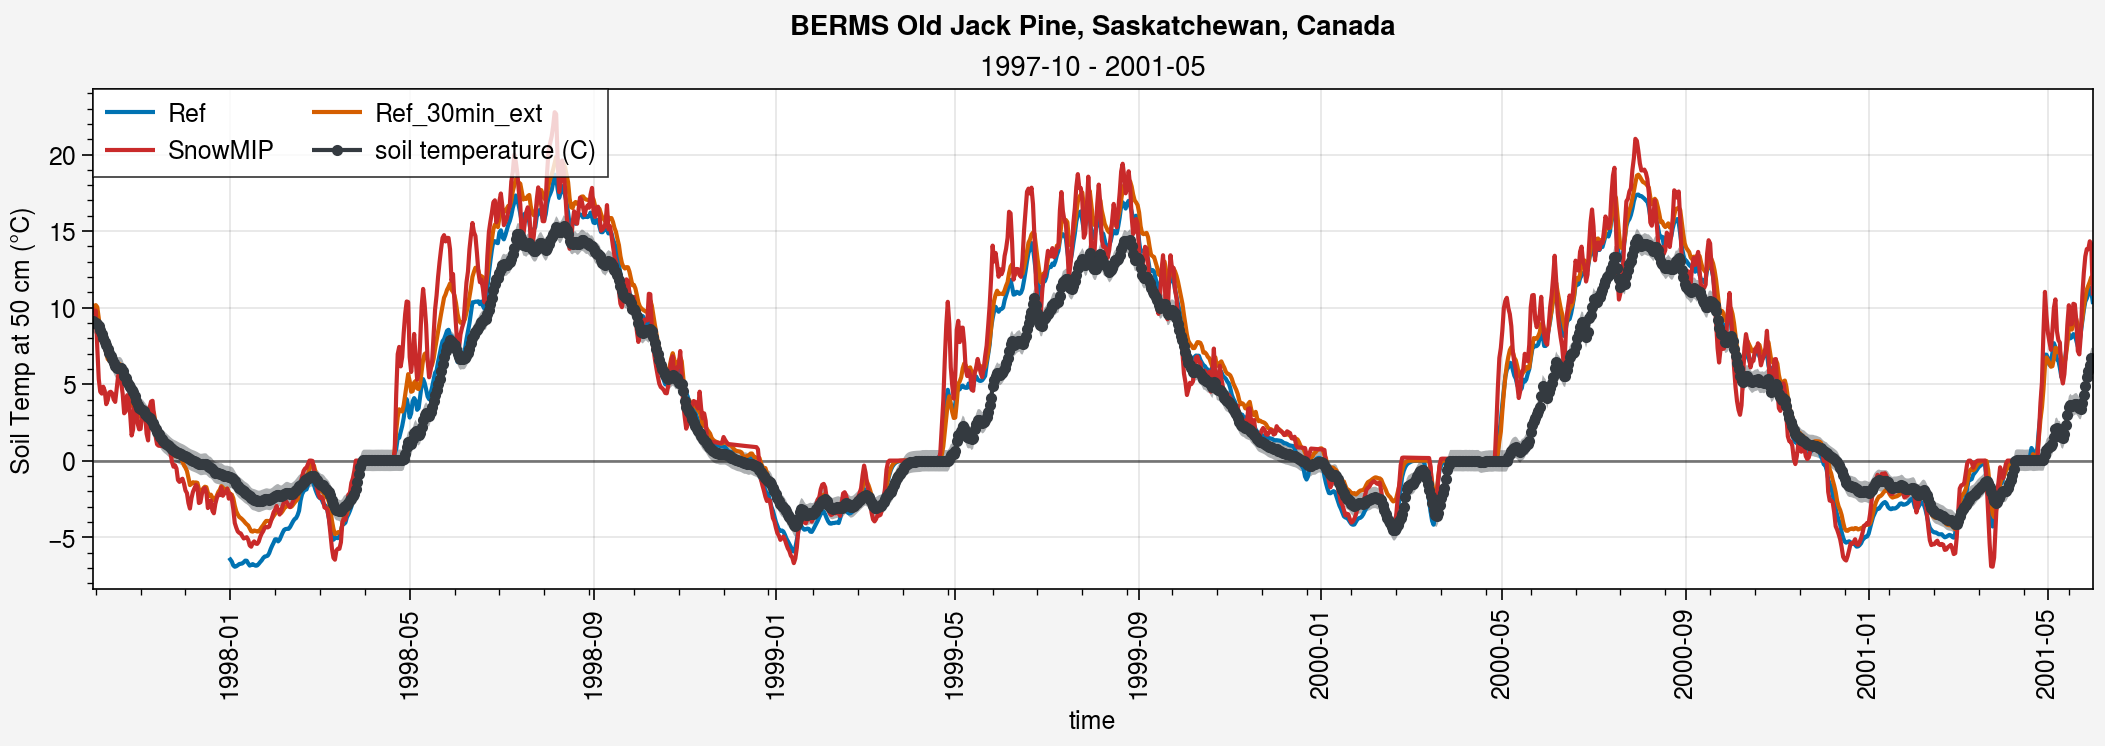

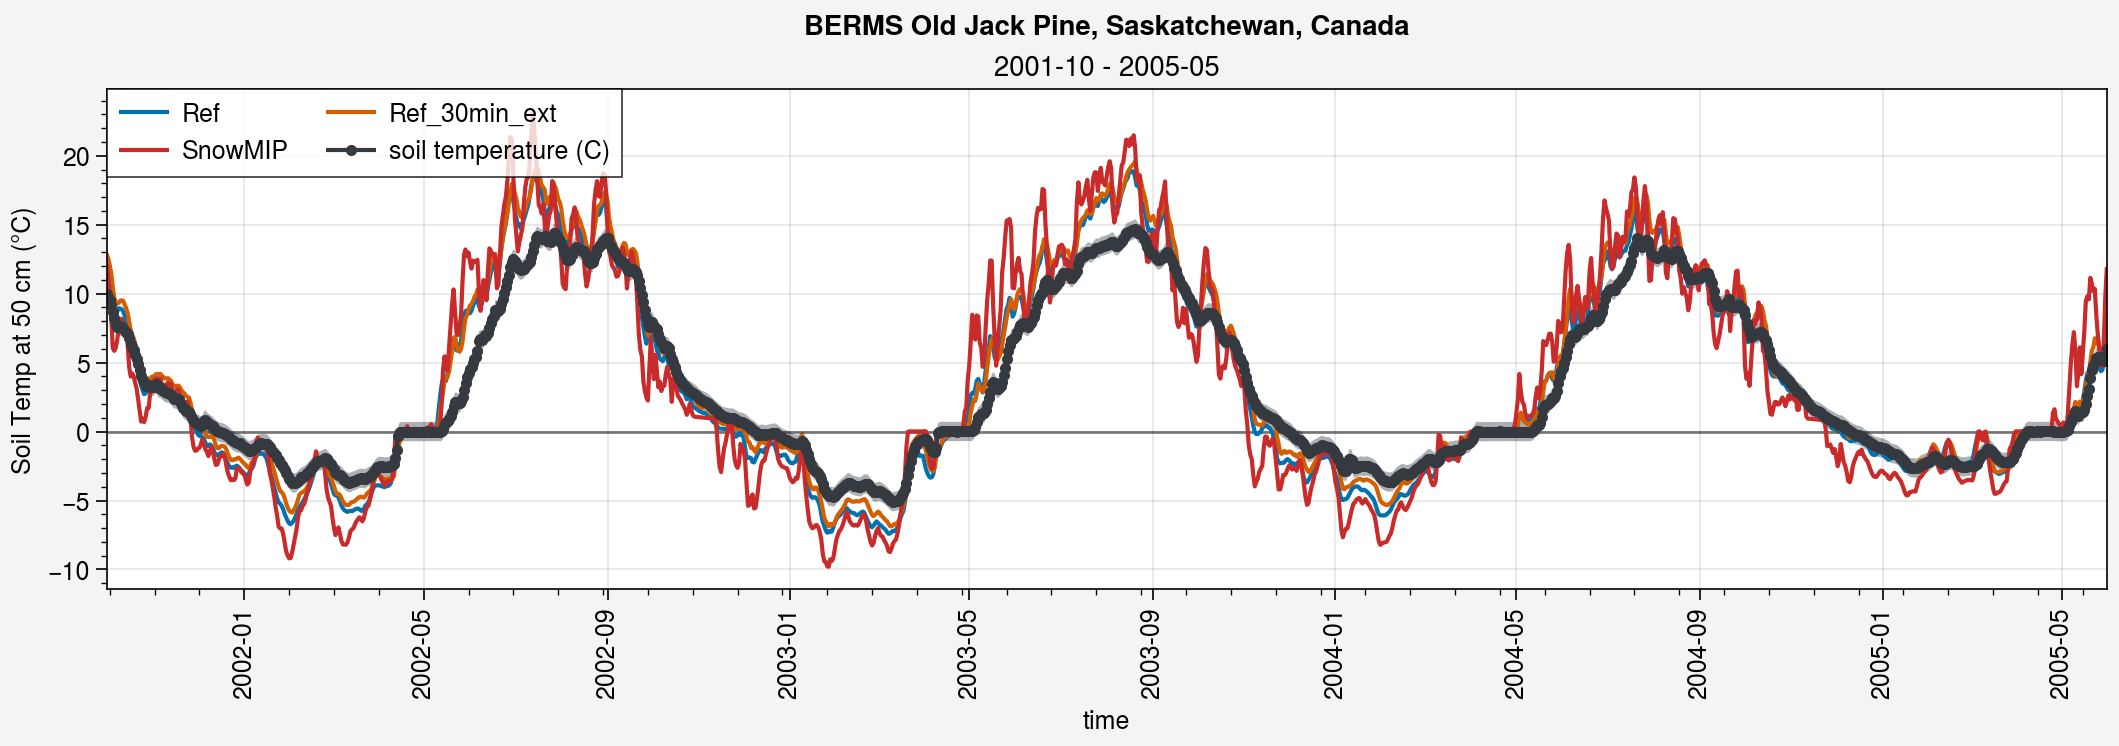

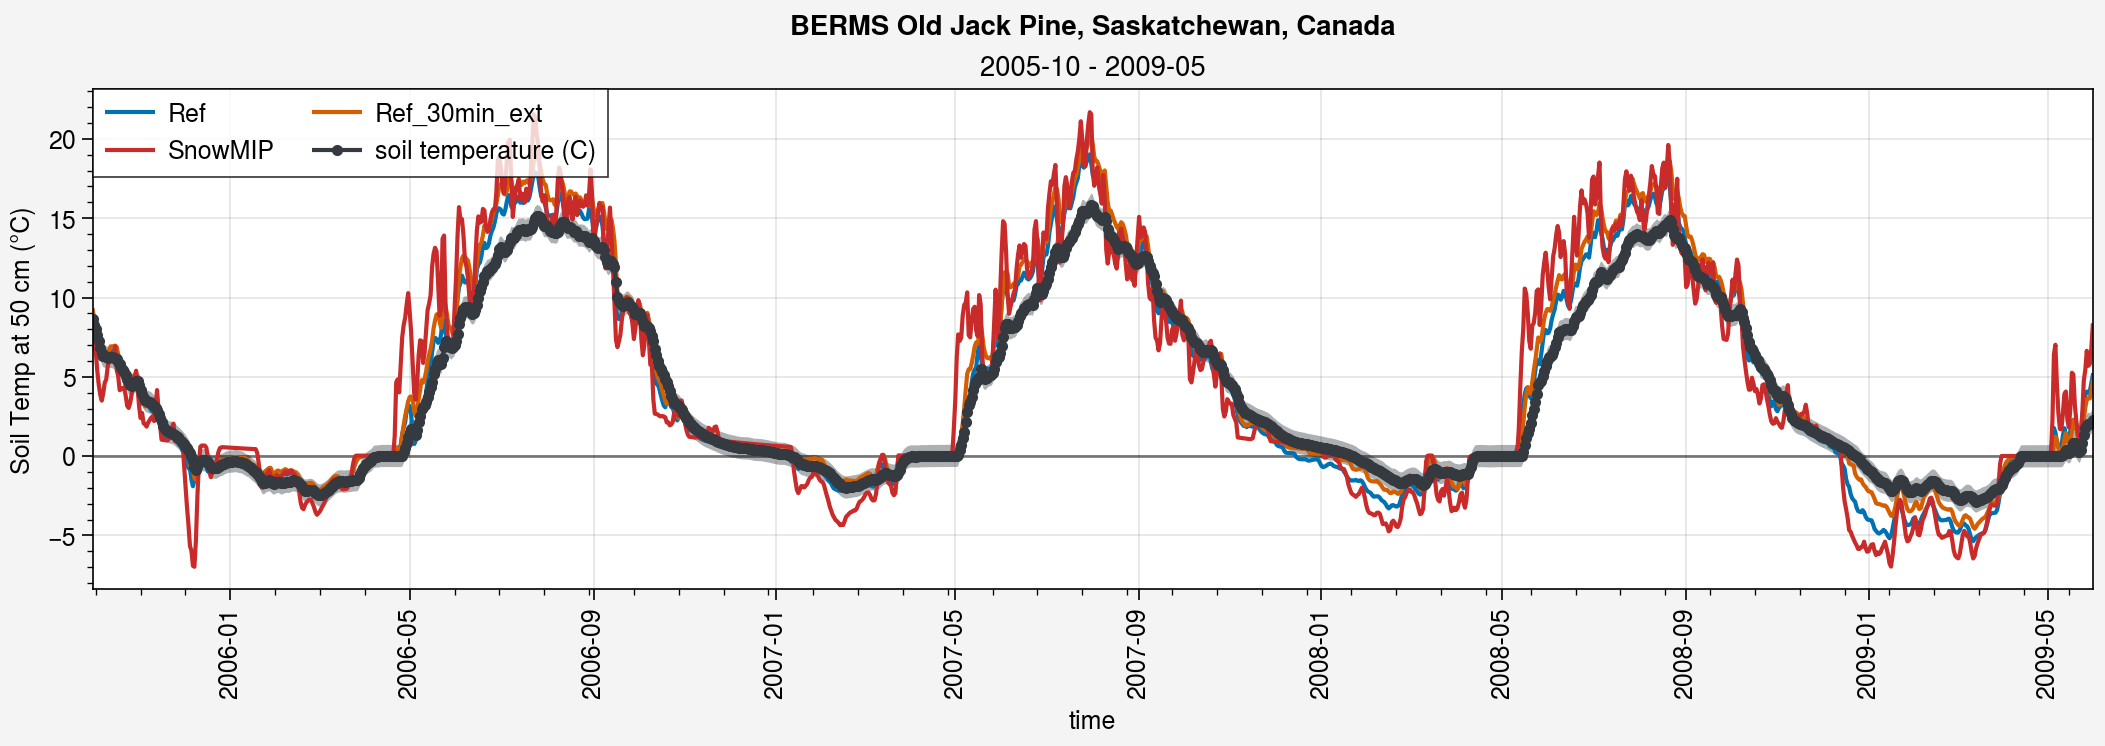

In [19]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-10',str(years[i*gap+gap])+'-05')
    else:
        period=slice(str(years[i*gap])+'-10',str(years[-1])+'-05')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        # axs[0].plot(((ds_d.tsl.sel(time=period, layer=2)+ds_d.tsl.sel(time=period, layer=3))/2)-273.15, label=label)
        # axs[0].plot(((ds_d.tsl.sel(time=period).isel(layer=1)+ds_d.tsl.sel(time=period).isel(layer=2))/2)-273.15, label=label)
        axs[0].plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_eval_menard2019.sdepth.values).sel(layer=0.5)-273.15, label=label)
    # axs[0].plot(ds_paul_d['tsl:2'].sel(time=period)-273.15, label=label_paul, color='red9')
    axs[0].plot(ds_paul_d.tsl.sel(time=period).interp(layer=ds_d_eval_menard2019.sdepth.values).sel(layer=0.5)-273.15, label=label_paul, color='red9')
    
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.5)+0.7, axis=0),
        np.expand_dims(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.5)-0.7, axis=0),), axis=0)
    axs[0].plot(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.5), shadedata=shadedata, marker='.', color=color_obs)
    
    
    axs[0].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Soil Temp at 50 cm (°C)')
    
    fig.suptitle(site_longname)
